In [1]:
# !pip install pytorch_forecasting

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("../../../../Users/ilyaz")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import numpy as np
import pandas as pd
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MultiHorizonMetric
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [3]:
DATA_PATH = "C:\Среда\CryptoGoModel\data"

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, 'AllData.csv'), parse_dates=['opentime'], index_col='opentime')
df = df.set_index('symbol', append=True).sort_index()

In [5]:
df.reset_index().columns

Index(['opentime', 'symbol', 'open', 'high', 'low', 'close', 'volume',
       'quoteassetvolume', 'tradenum', 'takerbuybaseassetvolume',
       'takerbuyquoteassetvolume', 'VWAP', 'volume_imbalance', 'spread',
       'liquidity_imbalance', 'max_bid_size', 'max_ask_size', 'max_bid_price',
       'max_ask_price', 'bid_vwap', 'ask_vwap', 'mid_price',
       'cum_bid_volume_5', 'cum_ask_volume_5', 'imbalance_level_5',
       'imbalance_level_10', 'Target'],
      dtype='object')

In [6]:
df = df.drop(['VWAP', 'takerbuyquoteassetvolume', 'takerbuybaseassetvolume', 'quoteassetvolume', 'cum_bid_volume_5', 'cum_ask_volume_5'], axis=1)


In [6]:
df.reset_index().columns

Index(['opentime', 'symbol', 'open', 'high', 'low', 'close', 'volume',
       'tradenum', 'volume_imbalance', 'spread', 'liquidity_imbalance',
       'max_bid_size', 'max_ask_size', 'max_bid_price', 'max_ask_price',
       'bid_vwap', 'ask_vwap', 'mid_price', 'imbalance_level_5',
       'imbalance_level_10', 'Target'],
      dtype='object')

In [7]:
itg_data_train = df.fillna(0)

In [8]:
timedelta = itg_data_train.index.get_level_values('opentime') - itg_data_train.index.get_level_values('opentime').min()
itg_data_train['time_idx'] = timedelta.total_seconds() / 60

In [9]:
minutes_since_midnight = itg_data_train.index.get_level_values('opentime').hour * 60 + itg_data_train.index.get_level_values('opentime').minute
itg_data_train['minutes_since_midnight'] = minutes_since_midnight

In [10]:
weight = pd.read_csv(os.path.join(DATA_PATH, 'symbolWeight.csv'), index_col='symbol')
itg_data_train = itg_data_train.join(weight)

In [11]:
itg_data_train = itg_data_train.reset_index()

In [12]:
itg_data_train['time_idx'] = itg_data_train['time_idx'].astype('int')
itg_data_train['symbol'] = itg_data_train['symbol'].astype('str')
itg_data_train['minutes_since_midnight'] = itg_data_train['minutes_since_midnight'].astype('str')

# Обучаем TFT

In [13]:
itg_data_test = itg_data_train[itg_data_train.opentime > '2024-09-07 11:21:00+00:00']
itg_data_train = itg_data_train[itg_data_train.opentime <= '2024-09-07 11:21:00+00:00']

In [14]:
max_prediction_length = 16
max_encoder_length = 80
training_cutoff = itg_data_train["time_idx"].max() - max_prediction_length
predict_cutoff = itg_data_train["time_idx"].max() - max_encoder_length

In [15]:
data_train = itg_data_train[lambda x: x.time_idx <= training_cutoff - max_encoder_length]

data_val = itg_data_train[lambda x: (x.time_idx > training_cutoff - max_encoder_length - max_encoder_length + max_prediction_length) & (x.time_idx <= training_cutoff - max_encoder_length + max_prediction_length)]
data_test = itg_data_train[lambda x: (x.time_idx > training_cutoff - max_encoder_length) & (x.time_idx <= training_cutoff)]
data_to_predict = itg_data_train[lambda x: x.time_idx > predict_cutoff]

In [16]:
scalers = {col: GroupNormalizer(groups=["symbol"]) for col in itg_data_train.columns}
del scalers['Target']
del scalers['opentime']
del scalers['symbol']
del scalers['time_idx']
del scalers['minutes_since_midnight']
del scalers['weight']

time_varying_known_reals = [col for col in itg_data_train.columns]
columns_to_remove = ['Target', 'opentime', 'symbol', 'minutes_since_midnight', 'weight']
for col in columns_to_remove:
    if col in time_varying_known_reals:
        time_varying_known_reals.remove(col)

training = TimeSeriesDataSet(
    data_train,
    time_idx="time_idx",
    target="Target",
    weight='weight',
    group_ids=["symbol"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["symbol"],
    static_reals=[],
    time_varying_known_categoricals=['minutes_since_midnight'],
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Target"
    ],
    target_normalizer=GroupNormalizer(
        groups=["symbol"]
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    scalers=scalers,
)

In [17]:
validation = TimeSeriesDataSet.from_dataset(training, data_val, predict=True, stop_randomization=True)
test = TimeSeriesDataSet.from_dataset(training, data_test, predict=True, stop_randomization=True)
predict_df = TimeSeriesDataSet.from_dataset(training, data_to_predict, predict=True, stop_randomization=True)


batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
predict_dataloader = predict_df.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
{'hidden_size': 150, 'lstm_layers': 3, 'dropout': 0.26688153298022127, 'learning_rate': 0.001112243401160169, 'attention_head_size': 4, 'hidden_continuous_size': 150}

In [18]:
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-2, patience=30, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=3,
    devices=1, accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    limit_train_batches=1.0,
    callbacks=[lr_logger, early_stop_callback],
    default_root_dir="/kaggle/working/",
)



tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    lstm_layers=3,
    hidden_size=150,
    attention_head_size=4,
    dropout=0.26688153298022127,
    hidden_continuous_size=150,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4
)
tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


Number of parameters in network: 6140.2k


In [19]:
del itg_data_train
del minutes_since_midnight
del df
import gc
gc.collect()

13594

In [20]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 135 K  | train
3  | prescalers                         | ModuleDict                      | 7.2 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 275 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.0 M  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 M  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 90.9 K | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [21]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
best_model_path

'\\kaggle\\working\\lightning_logs\\version_72\\checkpoints\\epoch=0-step=41573.ckpt'

In [22]:
MODEL_PATH = "C:\\Среда\\CryptoGoModel\\models"

In [23]:
import shutil

source = best_model_path
destination = os.path.join(MODEL_PATH, '1_epoch_80_No_vwap_mid.ckpt')


shutil.copy(source, destination)

'C:\\Среда\\CryptoGoModel\\models\\1_epoch_80_No_vwap_mid.ckpt'

In [18]:
best_tft = TemporalFusionTransformer.load_from_checkpoint('C:\\Среда\\CryptoGoModel\\models\\1_epoch_80_No_vwap_mid.ckpt')
best_tft.eval()
best_tft.cuda()

TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'Target', 'group_ids': ['symbol'], 'weight': 'weight', 'max_encoder_length': 80, 'min_encoder_length': 40, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 16, 'static_categoricals': ['symbol'], 'static_reals': ['encoder_length', 'Target_center', 'Target_scale'], 'time_varying_known_categoricals': ['minutes_since_midnight'], 'time_varying_known_reals': ['open', 'high', 'low', 'close', 'volume', 'tradenum', 'volume_imbalance', 'spread', 'liquidity_imbalance', 'max_bid_size', 'max_ask_size', 'max_bid_price', 'max_ask_price', 'bid_vwap', 'ask_vwap', 'mid_price', 'imbalance_level_5', 'imbalance_level_10', 'time_idx', 'relative_time_idx'], 'time_varying_unknown_categoricals': [], 'time_varying_unknown_reals': ['Target'], 'variable_gro

In [227]:
data_to_pred = data_test.sort_values('opentime').iloc[-616:]
aa = data_train.drop(['Target', 'time_idx', 'minutes_since_midnight', 'weight'], axis=1).sort_values('opentime')
data_to_pred['opentime'] = (data_to_pred['opentime'].view('int64') // 1_000_000).astype('int64')

In [228]:
aa.iloc[8000:3750+8000,:].to_csv(os.path.join(DATA_PATH, 'oldData.csv'), index=False)
data_to_pred.drop(['Target', 'time_idx', 'minutes_since_midnight', 'weight'], axis=1).to_csv(os.path.join(DATA_PATH, 'tes.csv'), index=False)

In [207]:
def ResidualizeMarket(df, mktColumn, window):
    if mktColumn not in df.columns:
        return df

    mkt = df[mktColumn]
    num = df.multiply(mkt.values, axis=0).rolling(window).mean()
    denom = mkt.multiply(mkt.values, axis=0).rolling(window).mean()
    beta = np.nan_to_num(num.values.T / denom.values, nan=0.0, posinf=0.0, neginf=0.0)

    resultRet = df - (beta * mkt.values).T
    resultBeta = 0.0 * df + beta.T

    return resultRet.drop(columns=[mktColumn]), resultBeta.drop(columns=[mktColumn])


def log_return_ahead(series, periods=1):
    return np.exp(-np.log(series).diff(periods=-periods).shift(-1)) - 1


def getTarget(df, assets_df, countData):
    prices = df.pivot(index=["opentime"], columns=["symbol"], values=["close"])
    log_returns_15min = log_return_ahead(prices, periods=15)
    weights = assets_df.weight.values
    weighted_avg_market_log_returns = log_returns_15min.mul(weights, axis='columns').div(
        log_returns_15min.notnull().mul(weights, axis='columns').sum(axis=1), axis=0).sum(axis=1)

    log_returns_15min["market"] = weighted_avg_market_log_returns
    residualized_market_returns, beta = ResidualizeMarket(log_returns_15min, "market", window=3750)

    residualized_market_returns_stacked = residualized_market_returns.stack('symbol', future_stack=True)

    residualized_market_returns_stacked.rename(columns={'close': 'Target'}, inplace=True)

    itg_data = df.set_index(['opentime', 'symbol']).join(residualized_market_returns_stacked).sort_index()[-countData:]


    itg_data = itg_data.fillna(0)
    timedelta = itg_data.index.get_level_values('opentime') - itg_data.index.get_level_values('opentime').min()
    itg_data['time_idx'] = timedelta.total_seconds() / 60

    minutes_since_midnight = itg_data.index.get_level_values('opentime').hour * 60 + itg_data.index.get_level_values('opentime').minute
    itg_data['minutes_since_midnight'] = minutes_since_midnight

    itg_data = itg_data.join(assets_df)
    itg_data = itg_data.reset_index()
    itg_data['time_idx'] = itg_data['time_idx'].astype('int')
    itg_data['symbol'] = itg_data['symbol'].astype('str')
    itg_data['minutes_since_midnight'] = itg_data['minutes_since_midnight'].astype('str')

    return itg_data

In [229]:
oldData = pd.read_csv(os.path.join(DATA_PATH, 'oldData.csv'), parse_dates=['opentime'])

currentData = pd.read_csv(os.path.join(DATA_PATH, "tes.csv"))

In [230]:
currentData['opentime'] = pd.to_datetime(currentData['opentime'] / 1000, unit='s', utc=True)
countData = currentData.shape[0]

oldData = pd.concat([oldData, currentData], axis=0)
oldData = oldData.drop_duplicates()
data_to_pred = getTarget(oldData.sort_values('opentime'), assets_df, countData)

In [ ]:
data_predictions = best_tft.predict(data_to_pred, mode="raw", return_x=True).output.prediction.cpu()

data_to_pred['opentime'] = (data_to_pred['opentime'].view('int64') // 1_000_000).astype('int64')


dates = sorted(data_to_pred['opentime'].unique())
symbols = sorted(data_to_pred.symbol.unique())

historicel_data = {symbol: {date: float(data_to_pred[(data_to_pred.opentime == date) & (data_to_pred.symbol == symbol)].Target.values[0]) for date in dates[:-16]} for symbol in symbols}
    
    
index = pd.MultiIndex.from_product([symbols, dates[-16:], range(7)], names=['symbol', 'timestamp', 'quantiles'])
prediction_df = pd.DataFrame(data_predictions.flatten(), index=index, columns=['target'])
prediction_df = prediction_df.reset_index()

out_pred = {
    symbol: {
        date: {
            f'quantile_{i}': float(prediction_df[(prediction_df.symbol == symbol) & (prediction_df.timestamp == date) & (prediction_df.quantiles == i)].target.values[0])
            for i in range(7)
        }
        for date in dates[-16:]
    }
    for symbol in symbols
}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [233]:
out_pred

{'ADAUSDT': {1725706200000: {'quantile_0': -0.0027131622,
   'quantile_1': -0.0022310738,
   'quantile_2': -0.0019258735,
   'quantile_3': -0.0016101657,
   'quantile_4': -0.0012938124,
   'quantile_5': -0.0009654983,
   'quantile_6': -0.0004491774},
  1725706260000: {'quantile_0': -0.0029383525,
   'quantile_1': -0.0023556373,
   'quantile_2': -0.0019910142,
   'quantile_3': -0.0016108722,
   'quantile_4': -0.0012406574,
   'quantile_5': -0.0008551714,
   'quantile_6': -0.00023520163},
  1725706320000: {'quantile_0': -0.0032686046,
   'quantile_1': -0.0025831873,
   'quantile_2': -0.0021523277,
   'quantile_3': -0.0017142437,
   'quantile_4': -0.001281897,
   'quantile_5': -0.0008503183,
   'quantile_6': -0.00018815561},
  1725706380000: {'quantile_0': -0.0035053124,
   'quantile_1': -0.0026986108,
   'quantile_2': -0.0021958626,
   'quantile_3': -0.0016782915,
   'quantile_4': -0.0011825653,
   'quantile_5': -0.0006840713,
   'quantile_6': 9.56509e-05},
  1725706440000: {'quantile_0'

In [232]:
historicel_data

{'ADAUSDT': {1725703800000: 0.0006182380216381844,
  1725703860000: 0.0012372409526755224,
  1725703920000: 0.0024760136180750347,
  1725703980000: 0.0015465511908443474,
  1725704040000: 0.0021645021645022577,
  1725704100000: 0.0021651716671822197,
  1725704160000: 0.0018552875695734272,
  1725704220000: 0.0018575851393187737,
  1725704280000: 0.0018575851393187737,
  1725704340000: 0.0009282178217822068,
  1725704400000: 0.0003091190108190922,
  1725704460000: -0.0006180469715698633,
  1725704520000: -0.0003089280197713373,
  1725704580000: -0.0006182380216384065,
  1725704640000: 0.0003093102381688251,
  1725704700000: -0.000926784059314234,
  1725704760000: -0.0006178560395426747,
  1725704820000: -0.0021611608521150405,
  1725704880000: -0.001235330450895633,
  1725704940000: -0.00154273372415914,
  1725705000000: -0.0009259259259259967,
  1725705060000: -0.0018518518518519933,
  1725705120000: 0.0006180469715697523,
  1725705180000: -0.00030902348578487615,
  1725705240000: 0.00

In [208]:
assets_df = pd.read_csv(os.path.join(DATA_PATH, 'symbolWeight.csv'), index_col="symbol")
assets_df.sort_index(inplace=True)

In [209]:
data_to_pred = getTarget(oldData.sort_values('opentime'), assets_df, countData)

In [210]:
data_to_pred

opentime    symbol         open         high  \
0   2024-09-07 10:10:00+00:00   ADAUSDT      0.32350      0.32380   
1   2024-09-07 10:10:00+00:00  AVAXUSDT     21.53000     21.55000   
2   2024-09-07 10:10:00+00:00   BNBUSDT    493.50000    493.70000   
3   2024-09-07 10:10:00+00:00   BTCUSDT  54332.01000  54349.00000   
4   2024-09-07 10:10:00+00:00  DOGEUSDT      0.09322      0.09332   
..                        ...       ...          ...          ...   
611 2024-09-07 11:05:00+00:00   LTCUSDT     63.85000     63.89000   
612 2024-09-07 11:05:00+00:00   MKRUSDT   1553.00000   1553.00000   
613 2024-09-07 11:05:00+00:00   SOLUSDT    127.47000    127.53000   
614 2024-09-07 11:05:00+00:00   TRXUSDT      0.14960      0.14970   
615 2024-09-07 11:05:00+00:00   XLMUSDT      0.08900      0.08900   

             low        close        volume  tradenum  volume_imbalance  \
0        0.32350      0.32370   20066.90000       105          0.039673   
1       21.53000     21.55000     374.88000        64          0.006707   
2      493.40000    493.50000      50.23900       414          0.070234   
3    54323.14000  54341.10000      46.78566      2052          0.193422   
4        0.09322      0.09332  215089.00000        70         -0.023572   
..           ...          ...           ...       ...               ...   
611     63.85000     63.89000      41.12900        30         -0.008123   
612   1553.00000   1553.00000       0.40500         1         -0.429132   
613    127.46000    127.52000     694.54500       315         -0.002352   
614      0.14960      0.14970   19297.90000        36          0.076554   
615      0.08900      0.08900     138.00000         1          0.134112   

           spread  ...  max_ask_price      bid_vwap      ask_vwap  \
0    3.106072e-04  ...         0.3247      0.320390      0.323435   
1    4.647920e-04  ...        21.7400     21.353527     21.699348   
2    2.023268e-04  ...       498.9000    492.782535    496.042331   
3    1.841790e-07  ...     54295.0000  54292.179067  54298.056540   
4    1.063208e-04  ...         0.0944      0.093908      0.094245   
..            ...  ...            ...           ...           ...   
611  1.573688e-04  ...        63.6000     63.428828     63.676914   
612  6.445375e-04  ...      1555.0000   1542.141127   1573.210545   
613  7.877427e-05  ...       127.1600    126.699177    127.130668   
614  6.646726e-04  ...         0.1505      0.149489      0.151345   
615  1.124227e-03  ...         0.0891      0.088051      0.089508   

        mid_price  imbalance_level_5  imbalance_level_10    Target  time_idx  \
0        0.321950           0.261134            0.112962  0.000618         0   
1       21.515000           0.154282            0.146152  0.001393         0   
2      494.250000           0.166185            0.158530  0.000811         0   
3    54294.995000           0.292264            0.202813 -0.001066         0   
4        0.094055           0.097524            0.142016  0.003107         0   
..            ...                ...                 ...       ...       ...   
611     63.545000          -0.135673           -0.078636  0.000000        55   
612   1551.500000           0.093042           -0.059838  0.000000        55   
613    126.945000          -0.060651           -0.178188  0.000000        55   
614      0.150450          -0.008523            0.031688  0.000000        55   
615      0.088950          -0.018784            0.069724  0.000000        55   

     minutes_since_midnight    weight  
0                       610  2.008502  
1                       610  1.853926  
2                       610  3.472220  
3                       610  5.636769  
4                       610  2.514712  
..                      ...       ...  
611                     665  1.341046  
612                     665  0.137945  
613                     665  3.434999  
614                     665  2.122507  
615                     665  0.838352  

[616 rows x 24 colum

In [88]:
data_predictions = best_tft.predict(data_to_pred, mode="raw", return_x=True).output.prediction.cpu()
# data_predictions_mean = torch.mean(data_predictions, dim=2)[:, 15].cpu()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [94]:
dates = sorted(data_to_pred['opentime'].unique())
symbols = sorted(data_to_pred.symbol.unique())
num_symbols = len(symbols)

In [113]:
data = {symbol: {date: data_to_pred[(data_to_pred.opentime == date) & (data_to_pred.symbol == symbol)].Target.values[0] for date in dates[:-16]} for symbol in symbols}

In [ ]:
index = pd.MultiIndex.from_product([symbols, dates[-16:], range(7)], names=['symbol', 'timestamp', 'quantiles'])
# Создаем DataFrame с соответствующими значениями
df = pd.DataFrame(data_predictions.flatten(), index=index, columns=['target'])

df = df.reset_index()

In [165]:
out_pred = {
    symbol: {
        date: {
            f'quantile_{i}': df[(df.symbol == symbol) & (df.timestamp == date) & (df.quantiles == i)].target.values[0]
            for i in range(7)
        }
        for date in dates[-16:]
    }
    for symbol in symbols
}

In [167]:
df

symbol      timestamp  quantiles    target
0     ADAUSDT  1725706200000          0 -0.003661
1     ADAUSDT  1725706200000          1 -0.003102
2     ADAUSDT  1725706200000          2 -0.002752
3     ADAUSDT  1725706200000          3 -0.002402
4     ADAUSDT  1725706200000          4 -0.002057
...       ...            ...        ...       ...
1227  XLMUSDT  1725707100000          2 -0.000950
1228  XLMUSDT  1725707100000          3  0.000146
1229  XLMUSDT  1725707100000          4  0.001231
1230  XLMUSDT  1725707100000          5  0.002265
1231  XLMUSDT  1725707100000          6  0.003991

[1232 rows x 4 columns]

In [168]:
out_pred['XLMUSDT']

{1725706200000: {'quantile_0': -0.0018405053,
  'quantile_1': -0.0010873367,
  'quantile_2': -0.00057778007,
  'quantile_3': 8.302228e-06,
  'quantile_4': 0.0006011668,
  'quantile_5': 0.0011356456,
  'quantile_6': 0.0019396112},
 1725706260000: {'quantile_0': -0.0020307293,
  'quantile_1': -0.0010928836,
  'quantile_2': -0.0004735004,
  'quantile_3': 0.00024111313,
  'quantile_4': 0.0009405174,
  'quantile_5': 0.0015880427,
  'quantile_6': 0.0026117829},
 1725706320000: {'quantile_0': -0.002551174,
  'quantile_1': -0.0015493142,
  'quantile_2': -0.00088972517,
  'quantile_3': -0.0001450748,
  'quantile_4': 0.00058744184,
  'quantile_5': 0.0012595706,
  'quantile_6': 0.0022910696},
 1725706380000: {'quantile_0': -0.0029717772,
  'quantile_1': -0.0018759513,
  'quantile_2': -0.0011612541,
  'quantile_3': -0.00035826513,
  'quantile_4': 0.0004220905,
  'quantile_5': 0.0011488007,
  'quantile_6': 0.0022808122},
 1725706440000: {'quantile_0': -0.0030624336,
  'quantile_1': -0.0019105076,
 

In [128]:
data_predictions[0, 1, 2]

tensor(-0.0025)

{1725703800000: -0.0006546899757361,
 1725703860000: -0.0004656002306642,
 1725703920000: -0.0008213320561693,
 1725703980000: -8.312206869141945e-06,
 1725704040000: 0.0002963198390972,
 1725704100000: 0.0021653503150225,
 1725704160000: 0.0015685737487662,
 1725704220000: 0.0024281354739876,
 1725704280000: 0.0022588509234164,
 1725704340000: 0.0024396941040363,
 1725704400000: 0.0023435835380123,
 1725704460000: 0.0019276435436872,
 1725704520000: 0.0014617621227461,
 1725704580000: 0.0011873815845734,
 1725704640000: 0.001042301523695,
 1725704700000: 0.0015294196480351,
 1725704760000: 0.0017007770215421,
 1725704820000: 0.0015993639674374,
 1725704880000: 0.00091547194586,
 1725704940000: 0.0005981828725863,
 1725705000000: -0.0013676662929723,
 1725705060000: -2.434129406153271e-05,
 1725705120000: -0.0008558303080285,
 1725705180000: 0.0008139394203516,
 1725705240000: 0.0004400271224095,
 1725705300000: 0.0004441993887283,
 1725705360000: 0.0004343102713314,
 1725705420000: 0.

In [90]:
historical_timestamps = dates[:-16]
prediction_timestamps = dates[-16:]

historical_targets = data_to_pred.set_index(['opentime', 'symbol'])[['Target']].sort_index().Target.values[:-16 * num_symbols]

prediction_targets = data_predictions

data_response = {}
predictions_response = {}

for symbol in symbols:
    symbol_historical_data = []
    symbol_prediction_data = []
        
    for i in range(16):
        timestamp = prediction_timestamps[i]
        target = historical_targets[i * num_symbols + symbols.index(symbol)]
        data_response.setdefault(symbol, []).append({
            "timestamp": timestamp,
            "target": target
        })
            
            # Assuming predictions have quantiles like quantile_1, quantile_2, etc.
        quantiles = data_predictions[i * num_symbols + symbols.index(symbol)].cpu().numpy()  # Adjust based on your model output
        predictions_response.setdefault(symbol, []).append({
            "timestamp": timestamp,
            "quantile_1": quantiles[0],
            "quantile_2": quantiles[1],
            "quantile_3": quantiles[2],
            "quantile_4": quantiles[3],
            "quantile_5": quantiles[4],
            "quantile_6": quantiles[5],
            "quantile_7": quantiles[6]
        })

IndexError: index 11 is out of bounds for dimension 0 with size 11

In [ ]:
data_to_pred = 

In [ ]:
out = d.set_index(['opentime', 'symbol'])[['Target']].sort_index().Target.values[:-16 * 11]

In [ ]:
dates = sorted((d['opentime'].view('int64') // 1_000_000).astype('int64').unique())
symbols = sorted(d.symbol.unique())
num_symbols = len(symbols)

historical_timestamps = dates[:-16]
prediction_timestamps = dates[-16:]

historical_targets = d.set_index(['opentime', 'symbol'])[['Target']].sort_index().Target.values[:-16 * num_symbols]

prediction_targets = data_predictions

In [84]:
data_predictions.shape

torch.Size([11, 16, 7])

In [81]:
out = d.set_index(['opentime', 'symbol'])[['Target']].sort_index().Target.values[:-16 * num_symbols]

In [83]:
len(out)

440

In [58]:
data_predictions.shape

torch.Size([11, 16, 7])

In [59]:
d = data_test.iloc[-616:]

In [40]:
dfdfdf = pd.read_csv(os.path.join(DATA_PATH, 'hello.csv'))

In [41]:
a = dfdfdf.copy()

In [42]:
dfdfdf['opentime'] = pd.to_datetime(dfdfdf['opentime'] / 1000, unit='s', utc=True)

In [35]:
dfdfdf['opentime'] = (dfdfdf['opentime'].view('int64') // 1_000_000).astype('int64')

In [38]:
a.opentime == dfdfdf.opentime

0      True
1      True
2      True
3      True
4      True
       ... 
414    True
415    True
416    True
417    True
418    True
Name: opentime, Length: 419, dtype: bool

In [36]:
dfdfdf

opentime    symbol         open         high          low  \
0    1733594040000   BTCUSDT  99558.82000  99597.38000  99540.95000   
1    1733602020000   SOLUSDT    242.76000    242.88000    242.73000   
2    1733602020000   ADAUSDT      1.21400      1.21490      1.21290   
3    1733602020000  DOGEUSDT      0.46254      0.46274      0.46187   
4    1733602020000   LTCUSDT    133.92000    133.97000    133.77000   
..             ...       ...          ...          ...          ...   
414  1733604240000  AVAXUSDT     52.28000     52.29000     52.25000   
415  1733604240000   ETHUSDT   4015.71000   4016.38000   4015.31000   
416  1733604240000   TRXUSDT      0.31850      0.31860      0.31850   
417  1733604240000   BNBUSDT    753.99000    754.16000    753.96000   
418  1733604240000   ADAUSDT      1.21120      1.21140      1.21000   

          close        volume  tradenum  volume_imbalance    spread  \
0    99597.3700  7.012950e+00      2917          0.112010  0.000000   
1      242.7800  1.855562e+03      1031         -0.159138  0.000041   
2        1.2134  1.293574e+05       372         -0.107386  0.000082   
3        0.4620  1.537739e+06      1952          0.175151  0.000022   
4      133.7800  9.730500e+01        79          0.216183  0.000075   
..          ...           ...       ...               ...       ...   
414     52.2500  2.021980e+03       259          0.245392  0.000191   
415   4015.9600  9.411210e+01       907         -0.321407  0.000002   
416      0.3186  1.124999e+05        95         -0.093285  0.000314   
417    754.0200  1.735810e+02       380         -0.004115  0.000013   
418      1.2100  4.846000e+04       127          0.255842  0.000083   

     liquidity_imbalance  max_bid_size  max_ask_size  max_bid_price  \
0               0.293626       2.41161       2.00482    99597.37000   
1               0.345372     508.53500    1657.88200      242.30000   
2              -0.029861  137355.50000  192575.60000        1.20920   
3               0.037969  173370.00000  189070.00000        0.46169   
4               0.930788     275.18100     506.13100      133.59000   
..                   ...           ...           ...            ...   
414            -0.230677    5967.07000    5378.58000       52.00000   
415            -0.846007      16.94310      84.05200     4014.88000   
416            -0.001992  587608.50000  533175.40000        0.31810   
417             0.819215      28.89700      64.34500      753.76000   
418             0.108797  188802.60000   50828.30000        1.20610   

     max_ask_price      bid_vwap      ask_vwap     mid_price  \
0      99601.66000  99593.542137  99604.357141  99597.375000   
1        243.00000    242.479405    243.034312    242.775000   
2          1.21600      1.211023      1.215860      1.213350   
3          0.46239      0.461718      0.462314      0.462005   
4        134.07000    133.547771    134.048729    133.775000   
..             ...           ...           ...           ...   
414       52.69000     52.050968     52.513148     52.245000   
415     4015.97000   4015.282017   4016.420094   4015.965000   
416        0.32210      0.317130      0.320479      0.318550   
417      754.34000    753.769716    754.329837    754.015000   
418        1.21160      1.207968      1.211964      1.210050   

     imbalance_level_5  imbalance_level_10  
0             0.556196            0.424749  
1             0.076281           -0.041850  
2             0.159834            0.191873  
3            -0.265442            0.049556  
4            -0.024478            0.223668  
..                 ...                 ...  
414           0.422839            0.415688  
415          -0.786619           -0.682966  
416           0.170450           -0.018074  
417           0.560876            0.509800  
418           0.023722            0.233380  

[419 rows x 20 columns]

In [21]:
data_predictions.shape

torch.Size([11, 16, 7])

In [20]:
data_predictions_mean

tensor([ 1.1874e-04, -1.9341e-04,  1.2377e-05,  1.5928e-05,  2.3545e-04,
        -2.1526e-05,  4.6515e-05,  1.4782e-04, -4.1699e-05,  2.3597e-05,
         1.8345e-04])

In [30]:
data_predictions = best_tft.predict(data_predddddd, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
from itertools import product
symbols = d.symbol.unique()
dates = pd.date_range(data_to_predict.date.min(), data_to_predict.date.max())

combinations = list(product(symbols, dates))

# Преобразуем комбинации в DataFrame
df_combinations = pd.DataFrame(combinations, columns=['symbol', 'opentime'])

# df_combinations = df_combinations.sort_values(['family', 'store_nbr', 'date'])
pred = data_predictions.output.prediction.reshape(28512, -1)
df_combinations['sales'] = pred.cpu()

In [ ]:
data_predictions.output.prediction.shape

torch.Size([1, 16, 7])

In [118]:


with torch.no_grad():  # Отключаем градиенты для оптимизации
    data_predictions = best_tft.predict(data_predddddd, mode="raw", return_x=True).output.prediction
    data_predictions_mean = torch.mean(data_predictions, dim=2)[:, 15]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [119]:
data_predictions = best_tft.predict(data_predddddd, mode="raw", return_x=True).output.prediction
data_predictions_mean = torch.mean(data_predictions, dim=2)[:, 15]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [109]:
aa = {'a': float(b[0].cpu())}

In [ ]:
aa

{'a': -0.002370530040934682}

In [72]:
sorted(data_test.symbol.unique())

['ADAUSDT',
 'AVAXUSDT',
 'BNBUSDT',
 'BTCUSDT',
 'DOGEUSDT',
 'ETHUSDT',
 'LTCUSDT',
 'MKRUSDT',
 'SOLUSDT',
 'TRXUSDT',
 'XLMUSDT']

In [75]:
data_predddddd = data_test.iloc[-616:]
data_predictions = best_tft.predict(data_predddddd, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [103]:
b.shape

torch.Size([16])

In [81]:
data_predddddd = data_test.iloc[-616:][data_test.symbol == 'ADAUSDT']
data_predictions = best_tft.predict(data_predddddd, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


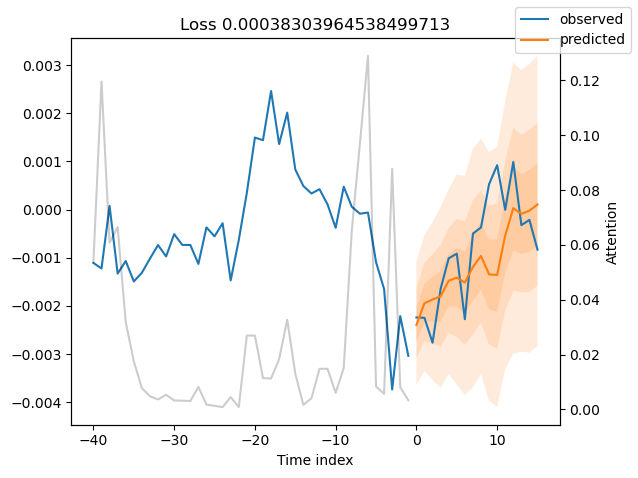

In [83]:
for idx in range(1):
    best_tft.plot_prediction(data_predictions.x, data_predictions.output, idx=idx, add_loss_to_title=True)

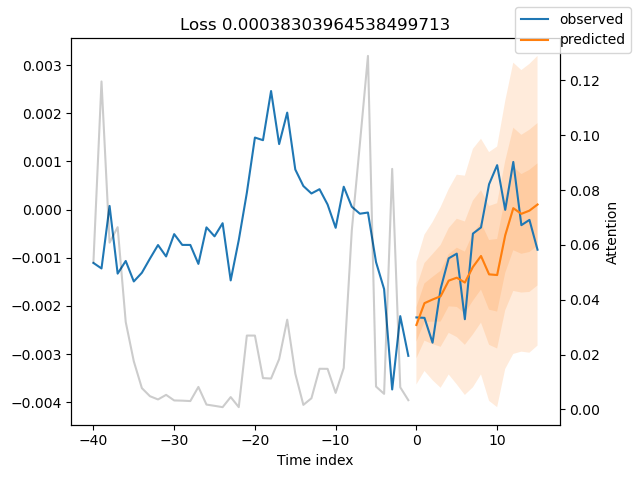

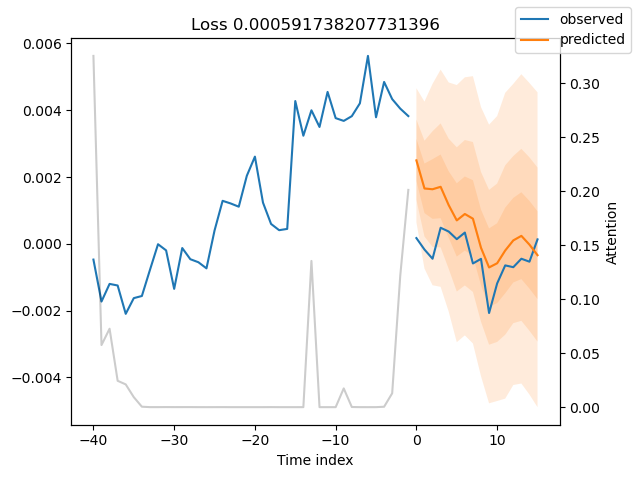

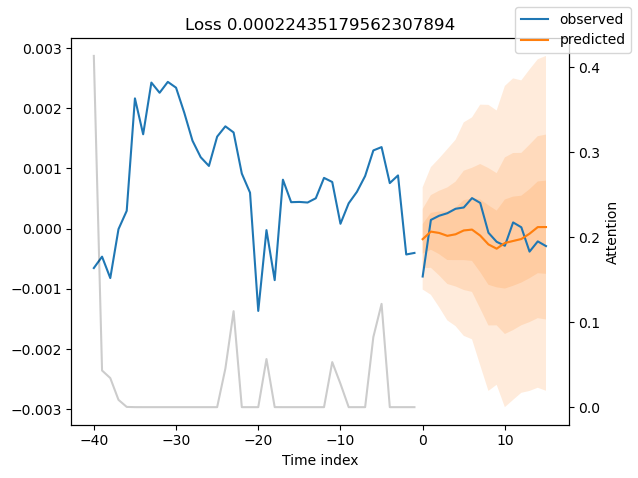

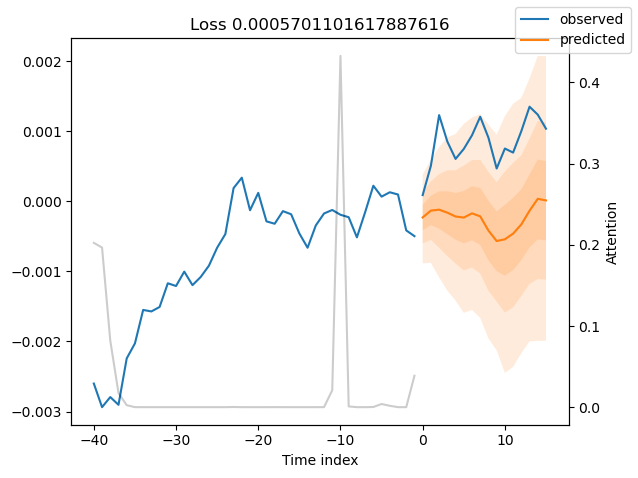

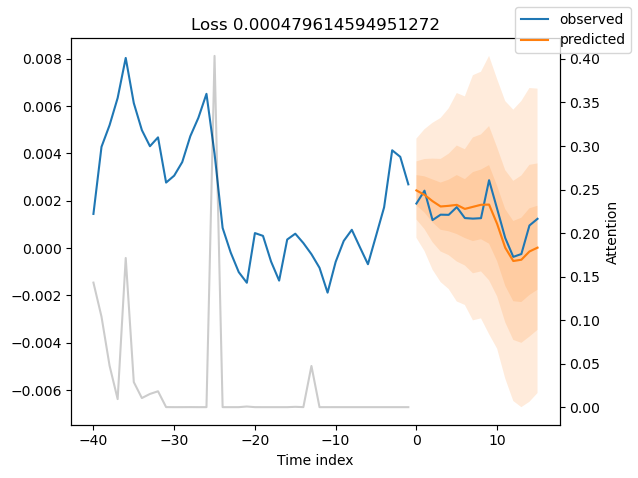

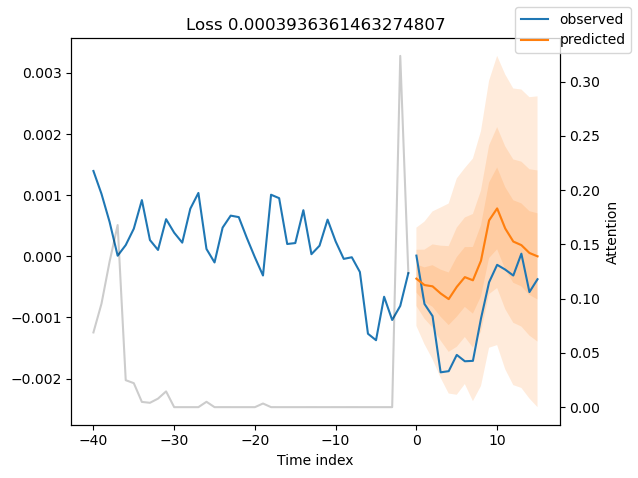

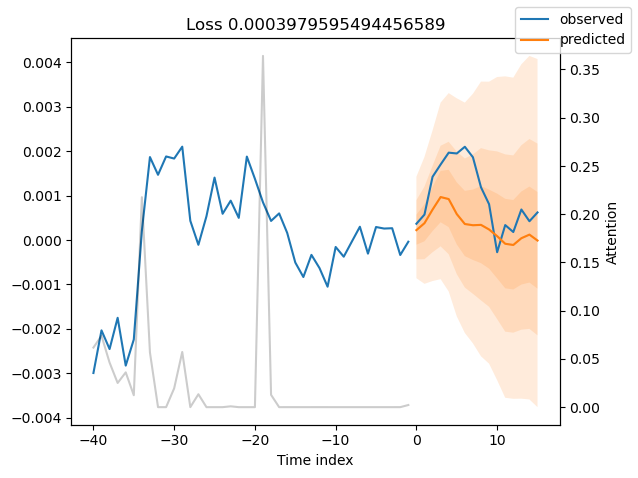

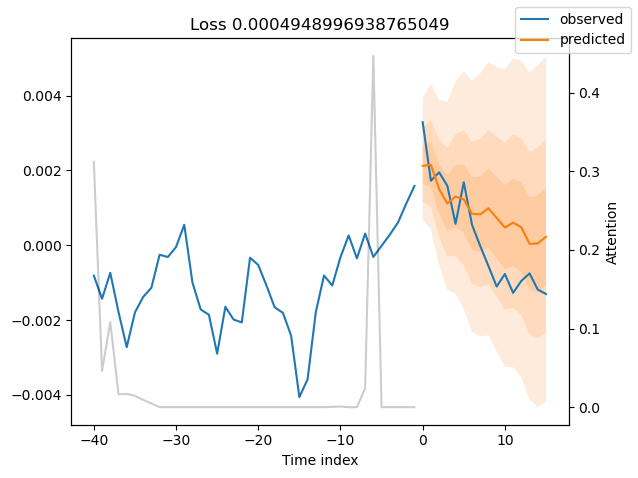

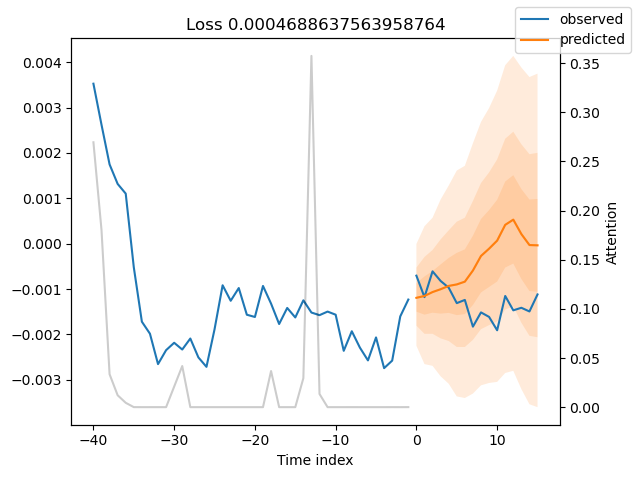

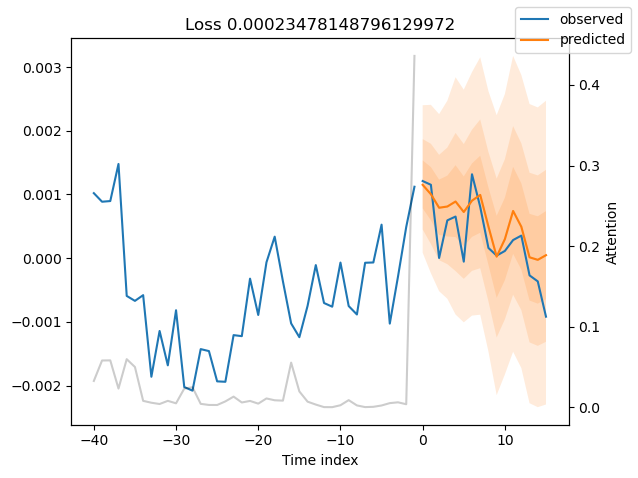

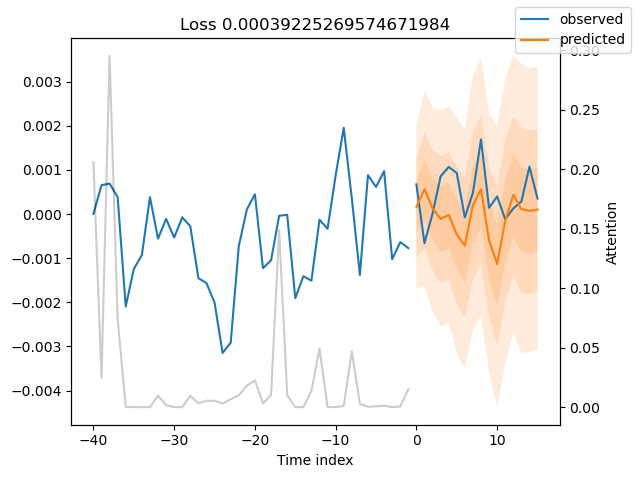

In [76]:
for idx in range(11):
    best_tft.plot_prediction(data_predictions.x, data_predictions.output, idx=idx, add_loss_to_title=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x775 with 1 Axes>,
 'decoder_variables': <Figure size 700x750 with 1 Axes>}

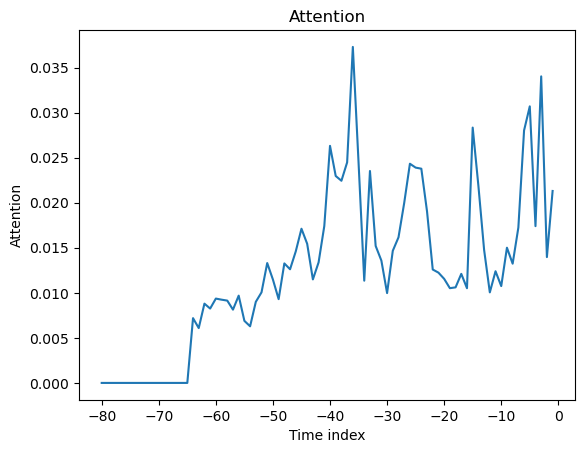

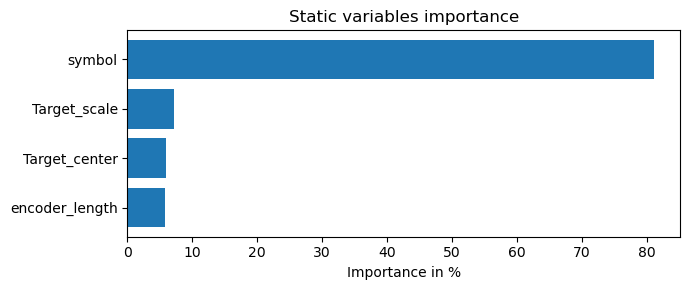

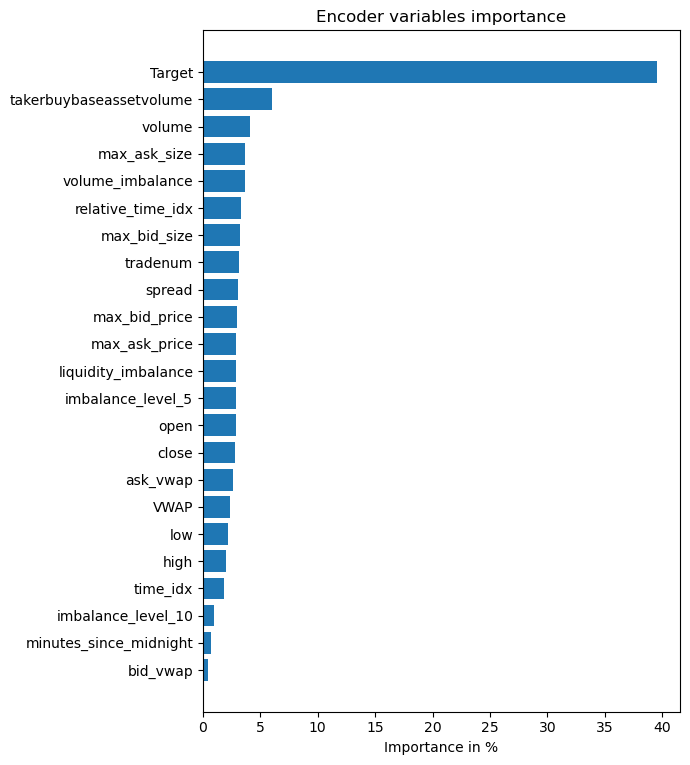

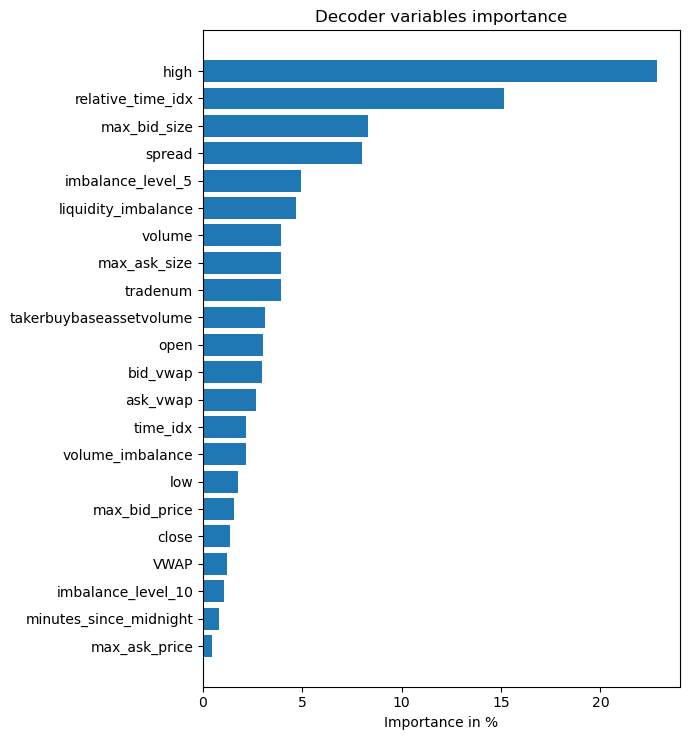

In [34]:
interpretation = best_tft.interpret_output(data_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [96]:
itg_data_test

opentime    symbol         open         high  \
5322240 2024-09-07 11:22:00+00:00   ADAUSDT      0.32230      0.32250   
5322241 2024-09-07 11:22:00+00:00  AVAXUSDT     21.61000     21.63000   
5322242 2024-09-07 11:22:00+00:00   BNBUSDT    493.70000    494.10000   
5322243 2024-09-07 11:22:00+00:00   BTCUSDT  54205.63000  54240.00000   
5322244 2024-09-07 11:22:00+00:00  DOGEUSDT      0.09395      0.09413   
...                           ...       ...          ...          ...   
5797435 2024-10-07 11:21:00+00:00   LTCUSDT     67.51000     67.51000   
5797436 2024-10-07 11:21:00+00:00   MKRUSDT   1455.00000   1455.00000   
5797437 2024-10-07 11:21:00+00:00   SOLUSDT    149.04000    149.11000   
5797438 2024-10-07 11:21:00+00:00   TRXUSDT      0.15460      0.15480   
5797439 2024-10-07 11:21:00+00:00   XLMUSDT      0.09280      0.09280   

                 low        close       volume  tradenum  \
5322240      0.32200      0.32240   65070.5000       174   
5322241     21.61000     21.63000     372.4300        26   
5322242    493.70000    494.10000     102.3140       351   
5322243  54205.62000  54232.82000      53.9014      1839   
5322244      0.09395      0.09413  295298.0000       264   
...              ...          ...          ...       ...   
5797435     67.48000     67.48000      80.5870       150   
5797436   1455.00000   1455.00000       0.0645         2   
5797437    148.96000    148.96000    1131.6760       654   
5797438      0.15460      0.15470  530829.6000        84   
5797439      0.09270      0.09270    3348.0000        31   

         takerbuybaseassetvolume          VWAP  ...  max_bid_price  \
5322240               21804.5000      0.322344  ...        0.32320   
5322241                 333.1000     21.468318  ...       21.53000   
5322242                  19.1520    496.750287  ...      492.70000   
5322243                  35.6409  55505.905142  ...    54443.99000   
5322244              273717.0000      0.094794  ...        0.09413   
...                          ...           ...  ...            ...   
5797435                  45.3760     66.431750  ...       66.03000   
5797436                   0.0645   1461.763771  ...     1404.00000   
5797437                 433.5210    145.271783  ...      146.30000   
5797438              416282.4000      0.154417  ...        0.15510   
5797439                   0.0000      0.092149  ...        0.09160   

         max_ask_price      bid_vwap      ask_vwap  imbalance_level_5  \
5322240        0.32590      0.321819      0.324841           0.133615   
5322241       21.74000     21.401906     21.724677           0.147373   
5322242      495.30000    491.928020    495.065570           0.063300   
5322243    54444.00000  54441.137691  54447.381605           0.431876   
5322244        0.09473      0.094163      0.094517          -0.041710   
...                ...           ...           ...                ...   
5797435       66.32000     66.064842     66.379705           0.022813   
5797436     1408.00000   1391.381174   1416.216845           0.285324   
5797437      146.94000    146.300102    146.827073          -0.027080   
5797438        0.15550      0.154553      0.156363           0.236126   
5797439        0.09200      0.090764      0.092578           0.130446   

         imbalance_level_10    Target  time_idx  minutes_since_midnight  \
5322240            0.080842 -0.003321    483840                     682   
5322241            0.164053  0.000105    483840                     682   
5322242            0.105678  0.001203    483840                     682   
5322243            0.445081 -0.000826    483840                     682   
5322244           -0.042681 -0.000037    483840                     682   
...                     ...       ...       ...                     ...   
5797435            0.007055  0.000000    527039                     681   
5797436            0.303169  0.000000    527039                     681   
5797437           -0.257650  0.000

In [17]:
itg_data_test_new = itg_data_test.iloc[:23760,]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available

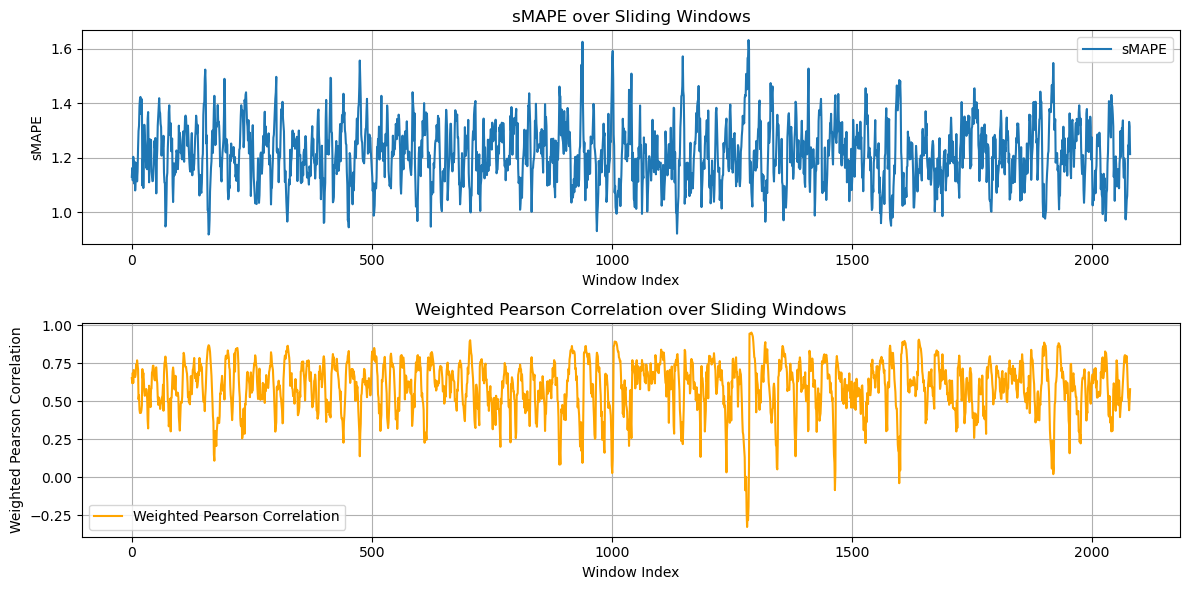

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_percentage_error

def smape(y_pred, y_true):
    return torch.mean(2 * torch.abs(y_pred - y_true) / (torch.abs(y_pred) + torch.abs(y_true) + 1e-8))

# Функция для расчета sMAPE
# Настройка параметров
window_size = 880
stride = 11  # Шаг скользящего окна
batch_smapes = []
batch_correlations = []

# Получение данных
data_length = len(itg_data_test_new)
num_windows = (data_length - window_size) // stride + 1

def weighted_mean(x, weights):
    return (x * weights).sum() / weights.sum()

def weighted_variance(x, weights, weighted_mean):
    return ((weights * (x - weighted_mean) ** 2).sum() / weights.sum())

def weighted_pearson_corr(y_true, y_pred, weights):
    mean_true = weighted_mean(y_true, weights)
    mean_pred = weighted_mean(y_pred, weights)

    var_true = weighted_variance(y_true, weights, mean_true)
    var_pred = weighted_variance(y_pred, weights, mean_pred)

    covariance = ((weights * (y_true - mean_true) * (y_pred - mean_pred)).sum() / weights.sum())
    
    return covariance / (torch.sqrt(var_true) * torch.sqrt(var_pred) + 1e-8)

# Проход скользящим окном по данным
for start in range(0, data_length - window_size + 1, stride):
    end = start + window_size
    val_predictions = best_tft.predict(itg_data_test_new[start:end], return_y=True)
    loss = smape(val_predictions.output, val_predictions.y[0])
    weights = val_predictions.y[1]
    weighted_loss = (loss * weights).sum() / weights.sum()

    batch_smapes.append(weighted_loss.item())

    # Вычисление коэффициента корреляции Пирсона с весами
    correlation = weighted_pearson_corr(val_predictions.y[0], val_predictions.output, weights)
    batch_correlations.append(correlation.item())

# Построение графиков
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(batch_smapes, label='sMAPE')
plt.xlabel('Window Index')
plt.ylabel('sMAPE')
plt.title('sMAPE over Sliding Windows')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(batch_correlations, label='Weighted Pearson Correlation', color='orange')
plt.xlabel('Window Index')
plt.ylabel('Weighted Pearson Correlation')
plt.title('Weighted Pearson Correlation over Sliding Windows')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
np.array(batch_correlations).mean()

np.float64(0.5954494600804995)

In [ ]:
val_predictions = best_tft.predict(test_dataloader, return_y=True)
def smape(y_pred, y_true):
    return torch.mean(2 * torch.abs(y_pred - y_true) / (torch.abs(y_pred) + torch.abs(y_true) + 1e-8))

# Вычисляем SMAPE
loss = smape(val_predictions.output, val_predictions.y[0])

# Теперь можно учесть веса, взвешивая среднее значение
weights = val_predictions.y[1]

# Взвешиваем SMAPE
weighted_loss = (loss * weights).sum() / weights.sum()

mean_losses = weighted_loss.item()
mean_losses

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.3301619291305542

In [51]:
def weighted_mean(x, weights):
    return (x * weights).sum() / weights.sum()

def weighted_variance(x, weights, weighted_mean):
    return ((weights * (x - weighted_mean) ** 2).sum() / weights.sum())

def weighted_pearson_corr(y_true, y_pred, weights):
    mean_true = weighted_mean(y_true, weights)
    mean_pred = weighted_mean(y_pred, weights)

    var_true = weighted_variance(y_true, weights, mean_true)
    var_pred = weighted_variance(y_pred, weights, mean_pred)

    covariance = ((weights * (y_true - mean_true) * (y_pred - mean_pred)).sum() / weights.sum())
    
    return covariance / (torch.sqrt(var_true) * torch.sqrt(var_pred) + 1e-8)

# Вычисляем коэффициент корреляции Пирсона с весами
pearson_corr = weighted_pearson_corr(val_predictions.y[0], val_predictions.output, val_predictions.y[1])

print("Weighted Pearson Correlation:", pearson_corr.item())

Weighted Pearson Correlation: 0.3553500473499298


## Проверка на новых данных

## OPTUNA

In [21]:
# !pip install optuna-integration

In [144]:
# from lightning.pytorch.callbacks.early_stopping import EarlyStopping


# pl.seed_everything(42)
# trainer_kwargs = dict(
#     limit_train_batches=10,
#     devices=1,
#     accelerator="gpu",
# )

Seed set to 42


In [147]:
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.4),
#     trainer_kwargs=trainer_kwargs,
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,
#     log_dir="/kaggle/working/",
# )

{'gradient_clip_val': 0.02216567221253469, 'hidden_size': 33, 'dropout': 0.349769428568029, 'hidden_continuous_size': 10, 'attention_head_size': 2, 'learning_rate': 0.01384396910404313}

## Обучаем

In [22]:
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-2, patience=30, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
# logger = TensorBoardLogger("lightning_logs")

pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=5,
    devices=1, accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    limit_train_batches=1.0,
    callbacks=[lr_logger, early_stop_callback],
    # logger=logger,
    default_root_dir="/kaggle/working/",
)



tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001172460885548076,
    lstm_layers=2,
    hidden_size=57,
    attention_head_size=3,
    dropout=0.12776721790404091,
    hidden_continuous_size=69,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4
)
tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


Number of parameters in network: 633.2k


In [24]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 82.2 K | train
3  | prescalers                         | ModuleDict                      | 1.8 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 44.1 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 152 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 136 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 13.3 K | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [25]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
best_model_path

'\\kaggle\\working\\lightning_logs\\version_58\\checkpoints\\epoch=0-step=57719.ckpt'

In [26]:
MODEL_PATH = "C:\Среда\KG\Competitions\G-Research Crypto Forecasting\TFT_models"

In [27]:
import shutil

source = best_model_path
destination = os.path.join(MODEL_PATH, '1epoch_90_new_weight_optuna_params.ckpt')


shutil.copy(source, destination)

'C:\\Среда\\KG\\Competitions\\G-Research Crypto Forecasting\\TFT_models\\1epoch_90_new_weight_optuna_params.ckpt'

'C:\\Users\\ilyaz\\new_training_logs\\lightning_logs\\version_22\\checkpoints\\epoch=51-step=5200.ckpt'

In [30]:
val_predictions = best_tft.predict(test_dataloader, return_y=True)
def smape(y_pred, y_true):
    return torch.mean(2 * torch.abs(y_pred - y_true) / (torch.abs(y_pred) + torch.abs(y_true) + 1e-8))

# Вычисляем SMAPE
loss = smape(val_predictions.output, val_predictions.y[0])

# Теперь можно учесть веса, взвешивая среднее значение
weights = val_predictions.y[1]

# Взвешиваем SMAPE
weighted_loss = (loss * weights).sum() / weights.sum()

mean_losses = weighted_loss.item()
mean_losses

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.3269706964492798

In [31]:
def weighted_mean(x, weights):
    return (x * weights).sum() / weights.sum()

def weighted_variance(x, weights, weighted_mean):
    return ((weights * (x - weighted_mean) ** 2).sum() / weights.sum())

def weighted_pearson_corr(y_true, y_pred, weights):
    mean_true = weighted_mean(y_true, weights)
    mean_pred = weighted_mean(y_pred, weights)

    var_true = weighted_variance(y_true, weights, mean_true)
    var_pred = weighted_variance(y_pred, weights, mean_pred)

    covariance = ((weights * (y_true - mean_true) * (y_pred - mean_pred)).sum() / weights.sum())
    
    return covariance / (torch.sqrt(var_true) * torch.sqrt(var_pred) + 1e-8)

# Вычисляем коэффициент корреляции Пирсона с весами
pearson_corr = weighted_pearson_corr(val_predictions.y[0], val_predictions.output, val_predictions.y[1])

print("Weighted Pearson Correlation:", pearson_corr.item())

Weighted Pearson Correlation: 0.3708595335483551


## Побдор параметров Optuna (с новой метрикой)

In [40]:
from pytorch_forecasting.metrics import Metric

class WeightedPearsonCorrelationMetric(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("sum_w", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("sum_wx", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("sum_wy", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("sum_wx2", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("sum_wy2", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("sum_wxy", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: tuple) -> None:
        weights = target[1]  # Веса
        target_values = target[0]  # Целевые значения

        self.sum_w += weights.sum()
        self.sum_wx += (weights * preds).sum()
        self.sum_wy += (weights * target_values).sum()
        self.sum_wx2 += (weights * preds * preds).sum()
        self.sum_wy2 += (weights * target_values * target_values).sum()
        self.sum_wxy += (weights * preds * target_values).sum()

    def compute(self) -> torch.Tensor:
        # Взвешенные средние значения
        mean_wx = self.sum_wx / self.sum_w
        mean_wy = self.sum_wy / self.sum_w
        
        # Числитель и знаменатель
        numerator = self.sum_wxy - self.sum_w * mean_wx * mean_wy
        denominator = torch.sqrt((self.sum_wx2 - self.sum_w * mean_wx * mean_wx) * 
                                 (self.sum_wy2 - self.sum_w * mean_wy * mean_wy))
        
        return torch.where(denominator != 0, numerator / denominator, torch.tensor(0.0))

# Теперь вы можете использовать эту метрику в вашей модели
weighted_pearson_forecasting_metric = WeightedPearsonCorrelationMetric()


In [21]:
# import optuna
# from pytorch_forecasting.metrics import MultiHorizonMetric

# pl.seed_everything(42)
# def objective(trial):
#     hidden_size = trial.suggest_int('hidden_size', 8, 128)
#     lstm_layers = trial.suggest_int('lstm_layers', 1, 3)
#     dropout = trial.suggest_float('dropout', 0.1, 0.3, log=True)
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
#     attention_head_size = trial.suggest_int('attention_head_size', 1, 4)
#     hidden_continuous_size = trial.suggest_int('hidden_continuous_size', 8, 128)

#     logger = TensorBoardLogger("lightning_logs", name="my_model")
#     early_stop_callback = EarlyStopping(monitor="val_WeightedPearsonCorrelationMetric", min_delta=1e-3, patience=10, verbose=False, mode="max")

#     lr_logger = LearningRateMonitor()

#     pl.seed_everything(42)
#     trainer = pl.Trainer(
#         max_epochs=50,
#         devices=1, accelerator="gpu",
#         enable_model_summary=False,
#         gradient_clip_val=0.01,
#         limit_train_batches=50,
#         callbacks=[lr_logger, early_stop_callback],
#         logger=logger, 
#         default_root_dir="/kaggle/working/",
#     )




#     model_tft = TemporalFusionTransformer.from_dataset(
#         training,
#         learning_rate=learning_rate,
#         lstm_layers=lstm_layers,
#         hidden_size=hidden_size,
#         attention_head_size=attention_head_size,
#         dropout=dropout,
#         hidden_continuous_size=hidden_continuous_size,
#         output_size=7,
#         loss=QuantileLoss(),
#         log_interval=10,
#         logging_metrics=[weighted_pearson_forecasting_metric],
#         reduce_on_plateau_patience=4
#     )
#     model_tft.to(DEVICE)

#     trainer.fit(
#         model_tft,
#         train_dataloaders=train_dataloader,
#         val_dataloaders=val_dataloader,
#     )



#     # Валидационная метрика
#     val_loss = trainer.callback_metrics["val_WeightedPearsonCorrelationMetric"]
#     return val_loss.item()

# # Запуск Optuna для оптимизации гиперпараметров
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

### Параметры

**Из kaggle {'hidden_size': 57, 'lstm_layers': 2, 'dropout': 0.12776721790404091, 'learning_rate': 0.001172460885548076, 'attention_head_size': 3, 'hidden_continuous_size': 69}
Локально {'hidden_size': 92, 'lstm_layers': 2, 'dropout': 0.11933026893587056, 'learning_rate': 0.0014611827844182108, 'attention_head_size': 2, 'hidden_continuous_size': 111}**

## Дообучаем на val

In [30]:
MODEL_PATH = "C:\Среда\KG\Competitions\G-Research Crypto Forecasting\TFT_models"

In [31]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(os.path.join(MODEL_PATH, '1epoch_90_new_weight_optuna_params.ckpt'))
best_tft.cuda();

In [32]:
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=1,
    devices=1, accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    limit_train_batches=1.0,
    # logger=logger,
    default_root_dir="/kaggle/working/",
)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


In [33]:
trainer.fit(
    best_tft,
    train_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 82.2 K | train
3  | prescalers                         | ModuleDict                      | 1.8 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 44.1 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 152 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 136 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 13.3 K | train
8  | static_context_initial_hidden_lstm |

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [34]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

## Проверяем на val

In [28]:
MODEL_PATH = "C:\Среда\KG\Competitions\G-Research Crypto Forecasting\TFT_models"

In [29]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(os.path.join(MODEL_PATH, '1epoch_90_new_weight_optuna_params.ckpt'))
best_tft.cuda();

In [36]:
data_predictions = best_tft.predict(data_val, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


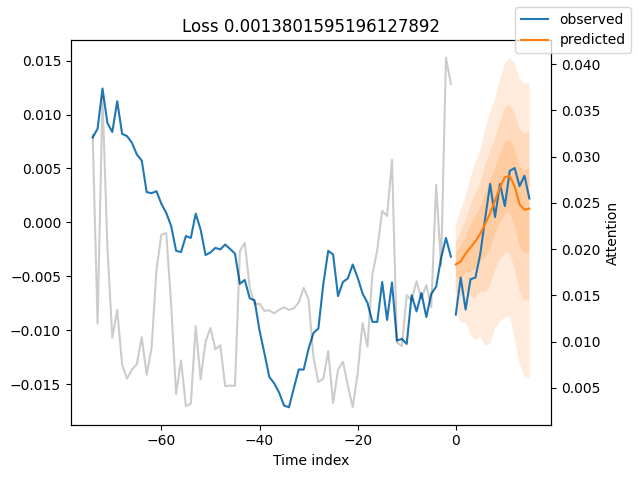

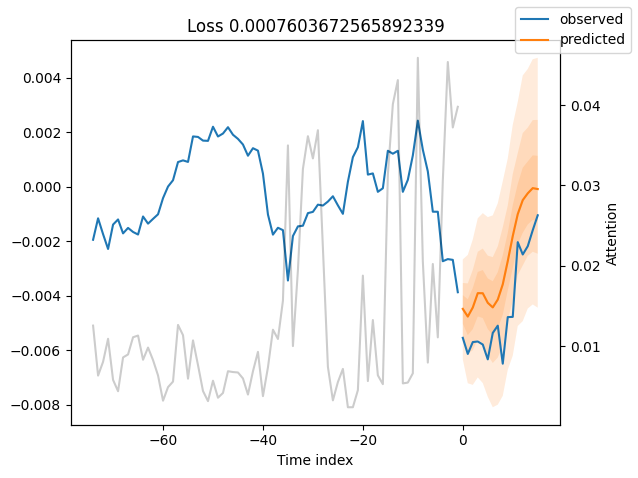

In [37]:
for idx in range(2):
    best_tft.plot_prediction(data_predictions.x, data_predictions.output, idx=idx, add_loss_to_title=True)

### Вычисляем метрики

In [38]:
val_predictions = best_tft.predict(val_dataloader, return_y=True)
def smape(y_pred, y_true):
    return torch.mean(2 * torch.abs(y_pred - y_true) / (torch.abs(y_pred) + torch.abs(y_true) + 1e-8))

# Вычисляем SMAPE
loss = smape(val_predictions.output, val_predictions.y[0])

# Теперь можно учесть веса, взвешивая среднее значение
weights = val_predictions.y[1]

# Взвешиваем SMAPE
weighted_loss = (loss * weights).sum() / weights.sum()

mean_losses = weighted_loss.item()
mean_losses

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.0764414072036743

In [39]:
def weighted_mean(x, weights):
    return (x * weights).sum() / weights.sum()

def weighted_variance(x, weights, weighted_mean):
    return ((weights * (x - weighted_mean) ** 2).sum() / weights.sum())

def weighted_pearson_corr(y_true, y_pred, weights):
    mean_true = weighted_mean(y_true, weights)
    mean_pred = weighted_mean(y_pred, weights)

    var_true = weighted_variance(y_true, weights, mean_true)
    var_pred = weighted_variance(y_pred, weights, mean_pred)

    covariance = ((weights * (y_true - mean_true) * (y_pred - mean_pred)).sum() / weights.sum())
    
    return covariance / (torch.sqrt(var_true) * torch.sqrt(var_pred) + 1e-8)

# Вычисляем коэффициент корреляции Пирсона с весами
pearson_corr = weighted_pearson_corr(val_predictions.y[0], val_predictions.output, val_predictions.y[1])

print("Weighted Pearson Correlation:", pearson_corr.item())

Weighted Pearson Correlation: 0.8450859785079956


## Проверяем на test

In [35]:
test_predictions = best_tft.predict(data_test, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


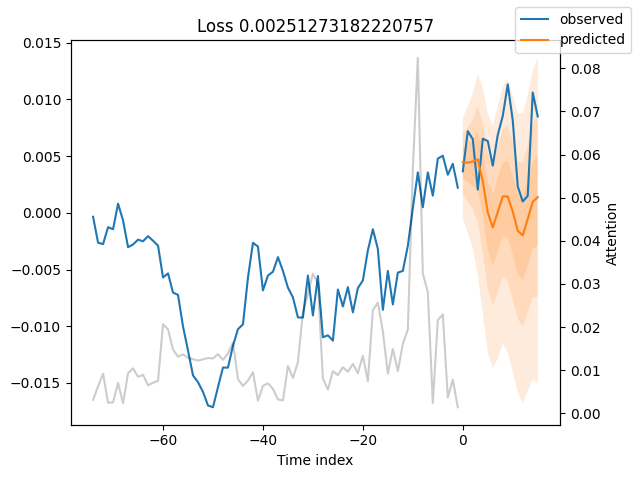

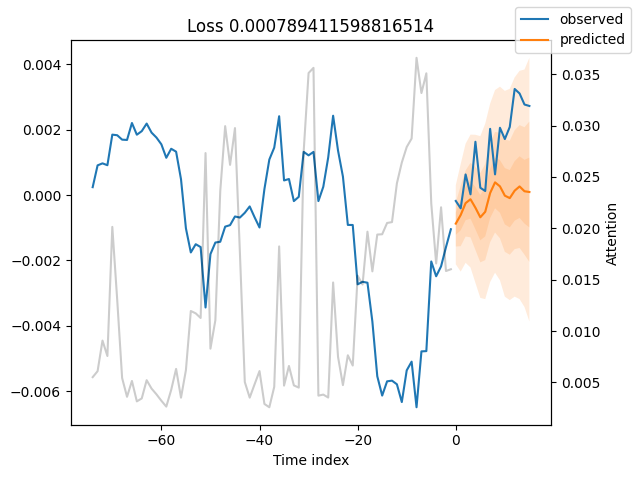

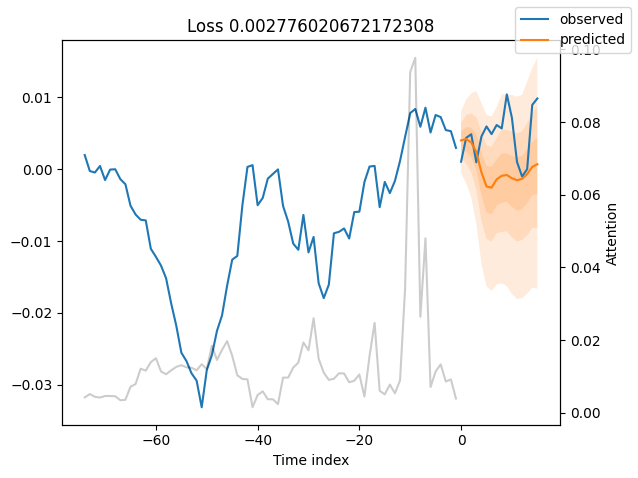

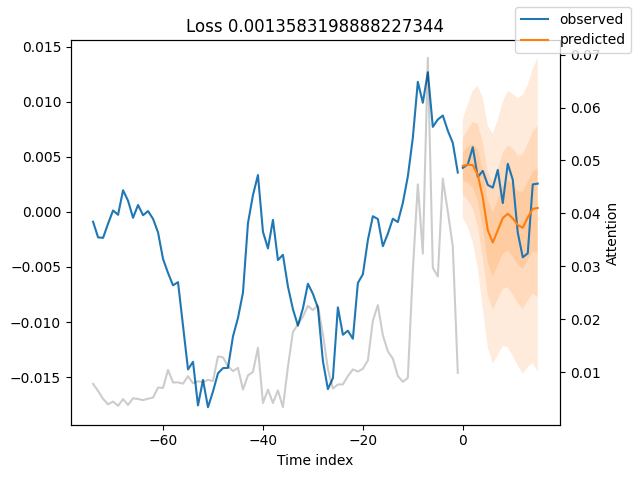

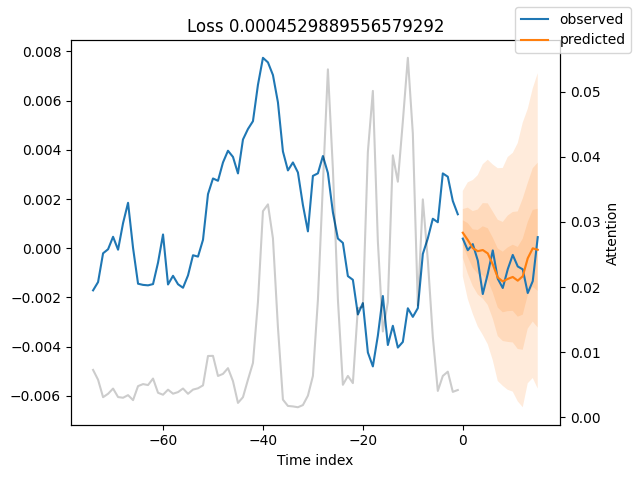

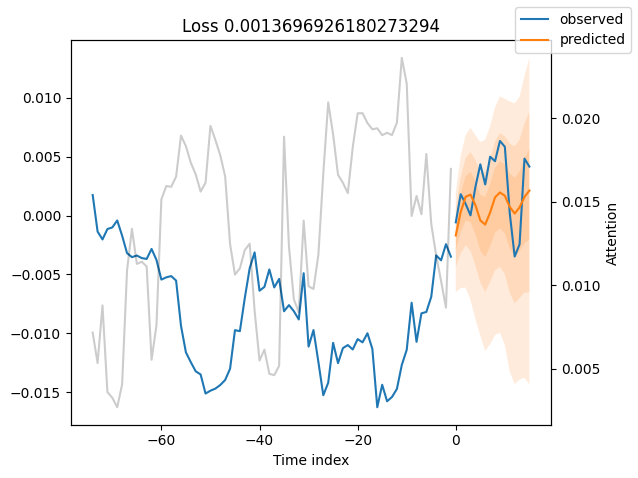

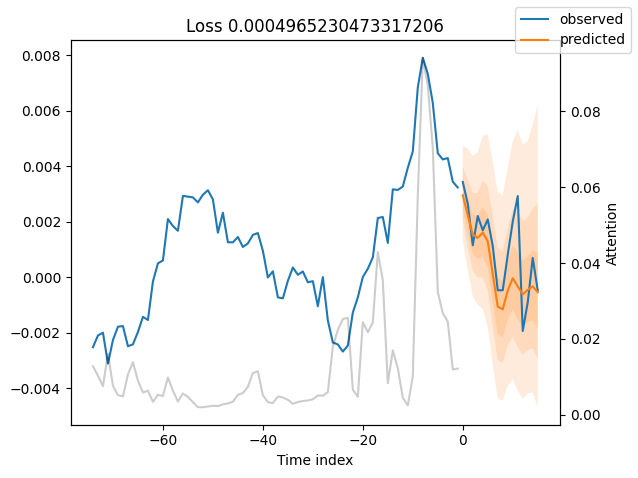

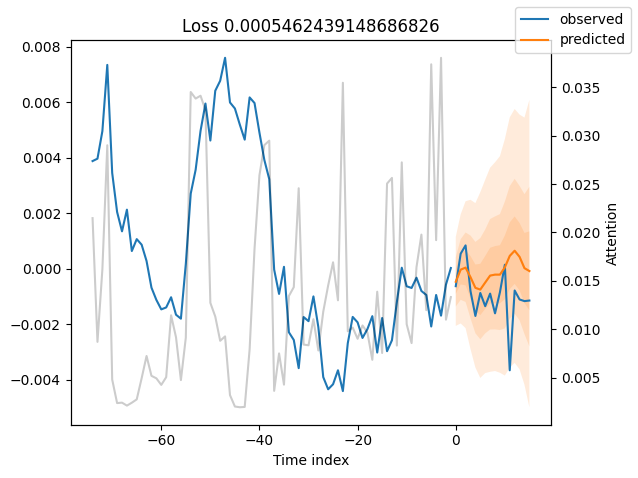

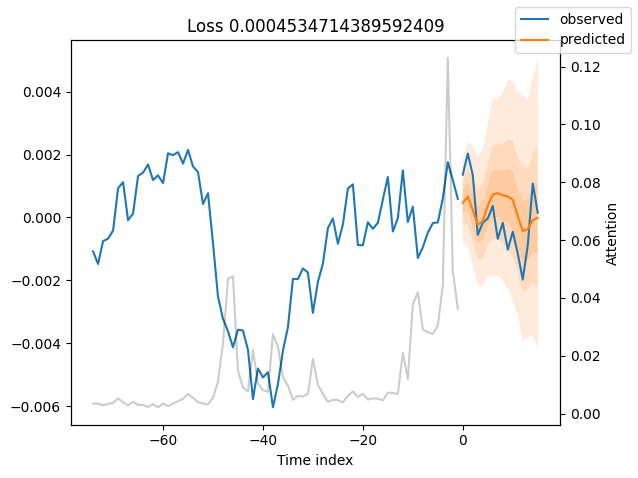

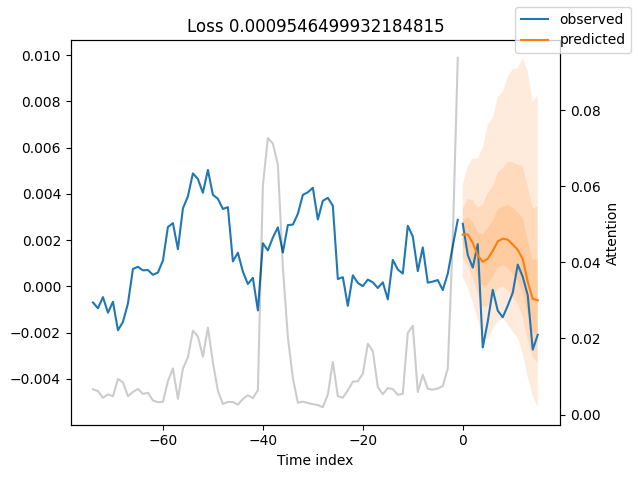

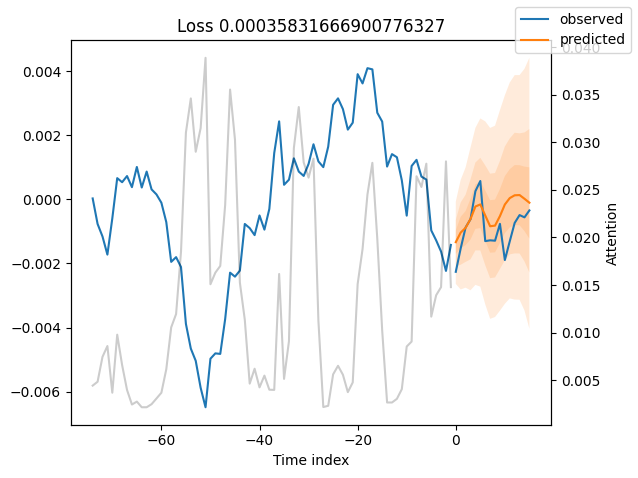

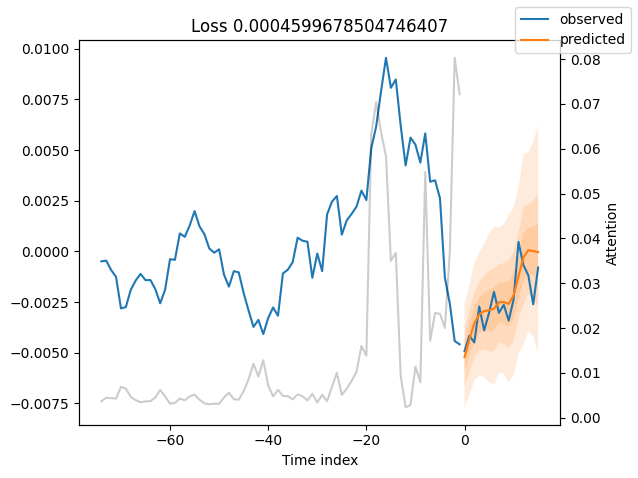

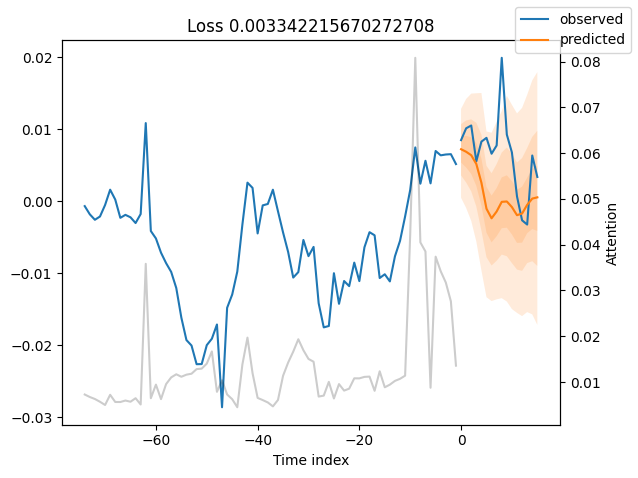

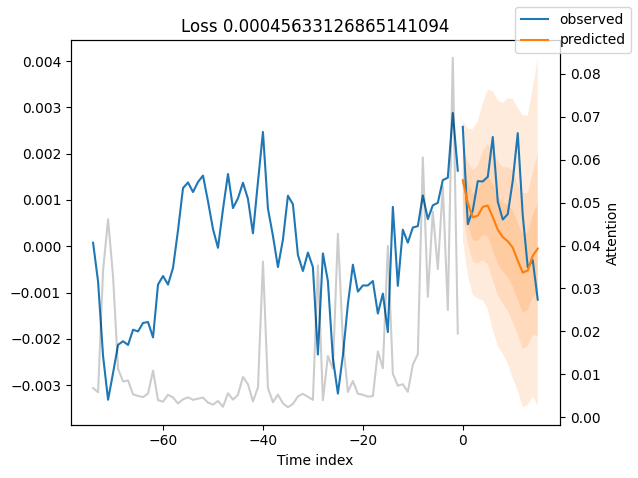

In [36]:
for idx in range(14):
    best_tft.plot_prediction(test_predictions.x, test_predictions.output, idx=idx, add_loss_to_title=True)

### Вычисляем метрики

In [37]:
test_predictions = best_tft.predict(test_dataloader, return_y=True)
def smape(y_pred, y_true):
    return torch.mean(2 * torch.abs(y_pred - y_true) / (torch.abs(y_pred) + torch.abs(y_true) + 1e-8))

# Вычисляем SMAPE
loss = smape(test_predictions.output, test_predictions.y[0])

# Теперь можно учесть веса, взвешивая среднее значение
weights = test_predictions.y[1]

# Взвешиваем SMAPE
weighted_loss = (loss * weights).sum() / weights.sum()

mean_losses = weighted_loss.item()
mean_losses

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.248308777809143

In [38]:
def weighted_mean(x, weights):
    return (x * weights).sum() / weights.sum()

def weighted_variance(x, weights, weighted_mean):
    return ((weights * (x - weighted_mean) ** 2).sum() / weights.sum())

def weighted_pearson_corr(y_true, y_pred, weights):
    mean_true = weighted_mean(y_true, weights)
    mean_pred = weighted_mean(y_pred, weights)

    var_true = weighted_variance(y_true, weights, mean_true)
    var_pred = weighted_variance(y_pred, weights, mean_pred)

    covariance = ((weights * (y_true - mean_true) * (y_pred - mean_pred)).sum() / weights.sum())
    
    return covariance / (torch.sqrt(var_true) * torch.sqrt(var_pred) + 1e-8)

# Вычисляем коэффициент корреляции Пирсона с весами
pearson_corr = weighted_pearson_corr(test_predictions.y[0], test_predictions.output, test_predictions.y[1])

print("Weighted Pearson Correlation:", pearson_corr.item())

Weighted Pearson Correlation: 0.4819144606590271


## Оценка чего-то

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Target_center': <Figure size 1000x500 with 2 Axes>,
 'Target_scale': <Figure size 1000x500 with 2 Axes>,
 'Count': <Figure size 1000x500 with 2 Axes>,
 'Open': <Figure size 1000x500 with 2 Axes>,
 'High': <Figure size 1000x500 with 2 Axes>,
 'Low': <Figure size 1000x500 with 2 Axes>,
 'Close': <Figure size 1000x500 with 2 Axes>,
 'Volume': <Figure size 1000x500 with 2 Axes>,
 'VWAP': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Target': <Figure size 1000x500 with 2 Axes>,
 'Asset_ID': <Figure size 1000x500 with 2 Axes>,
 'minutes_since_midnight': <Figure size 1000x500 with 2 Axes>}

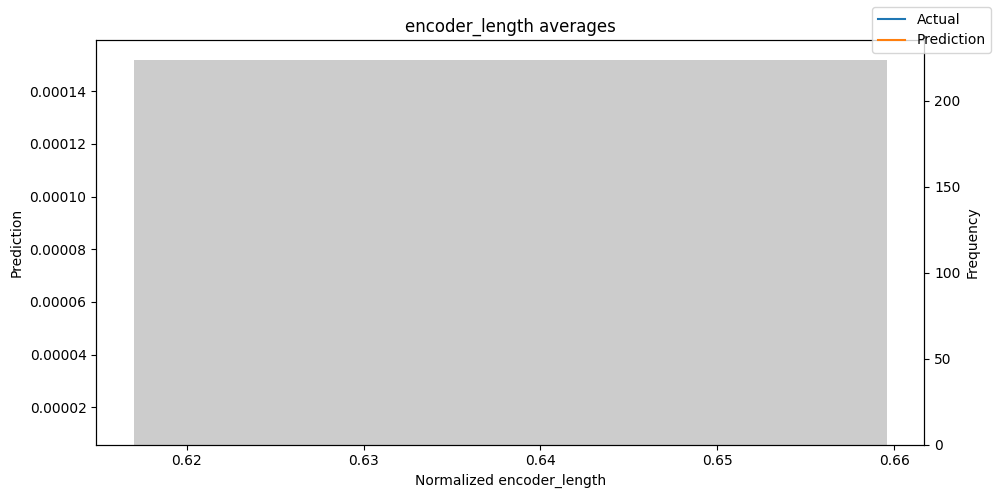

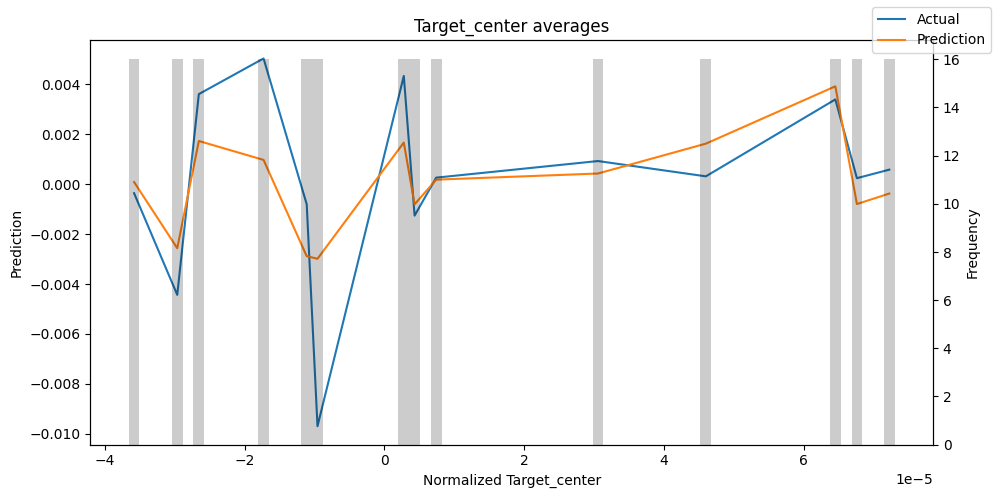

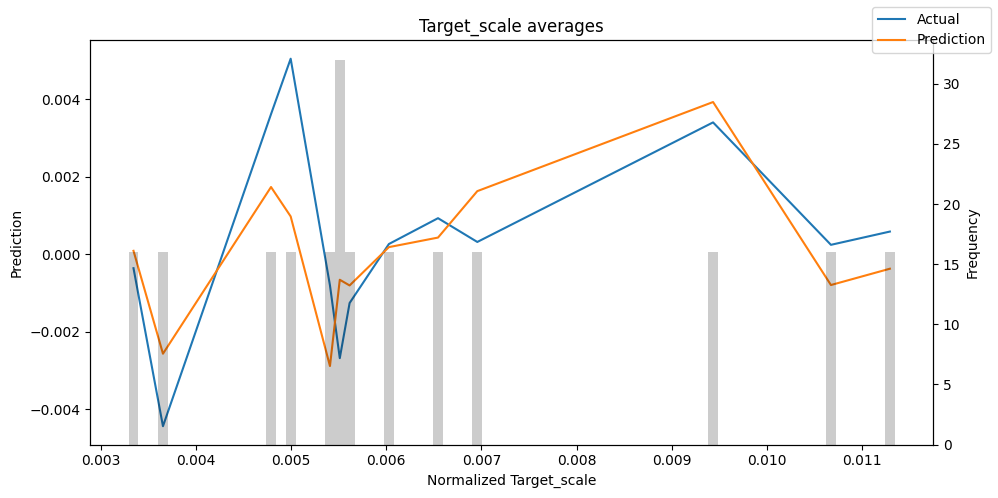

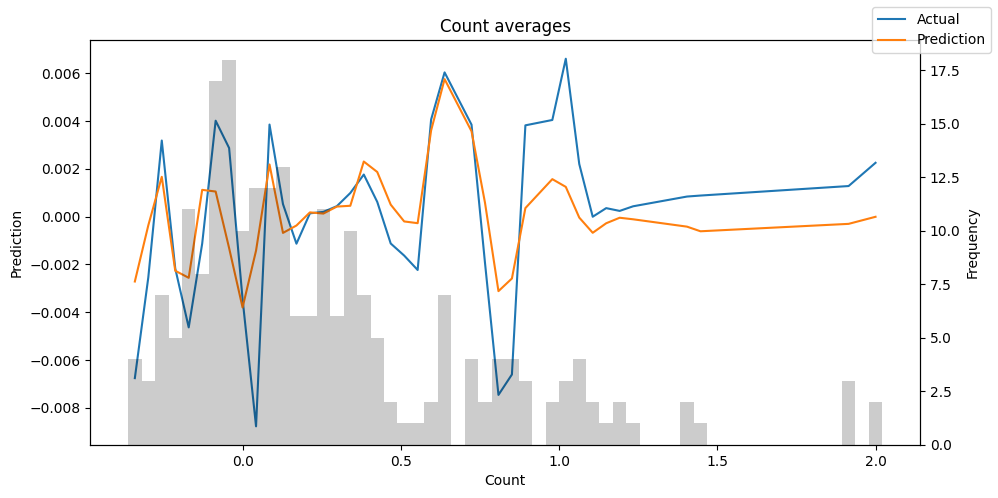

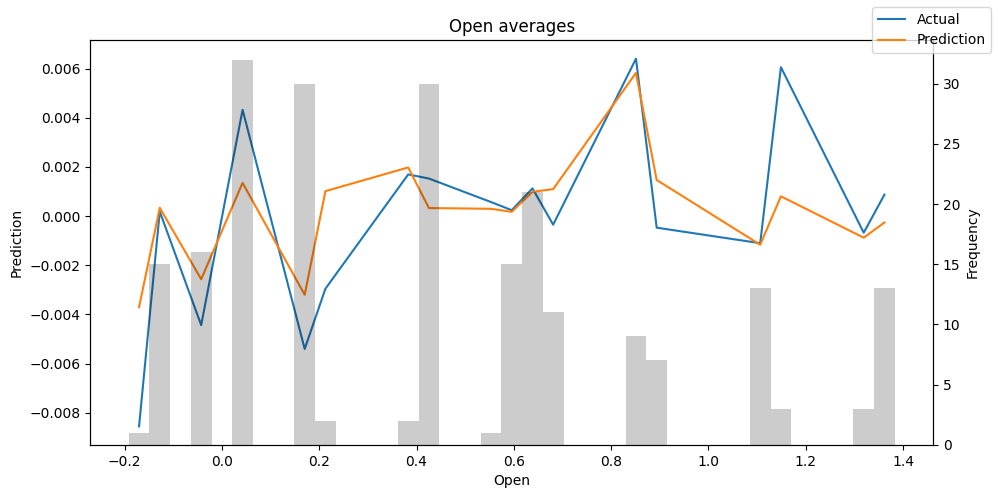

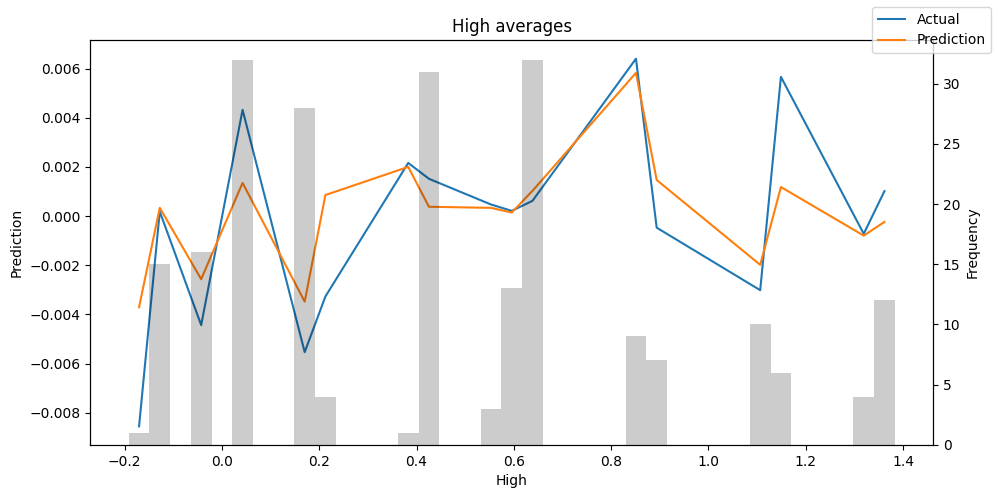

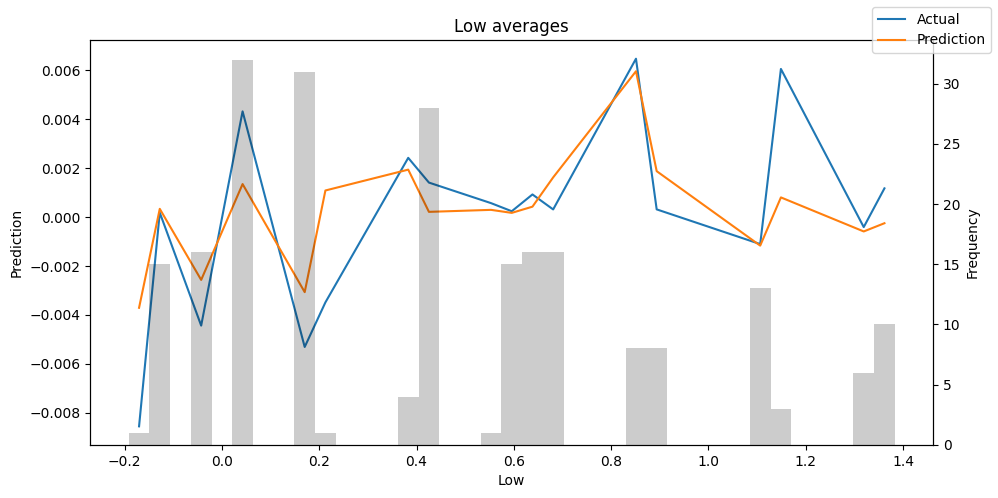

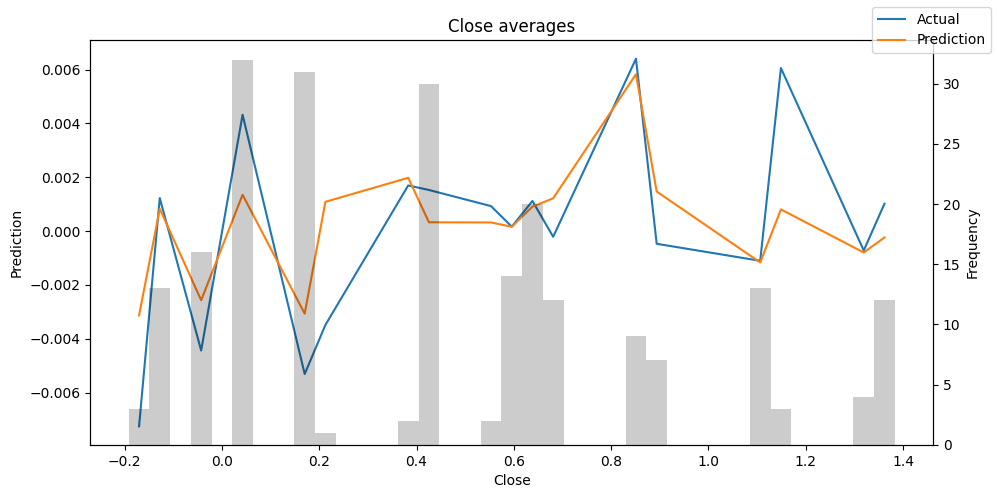

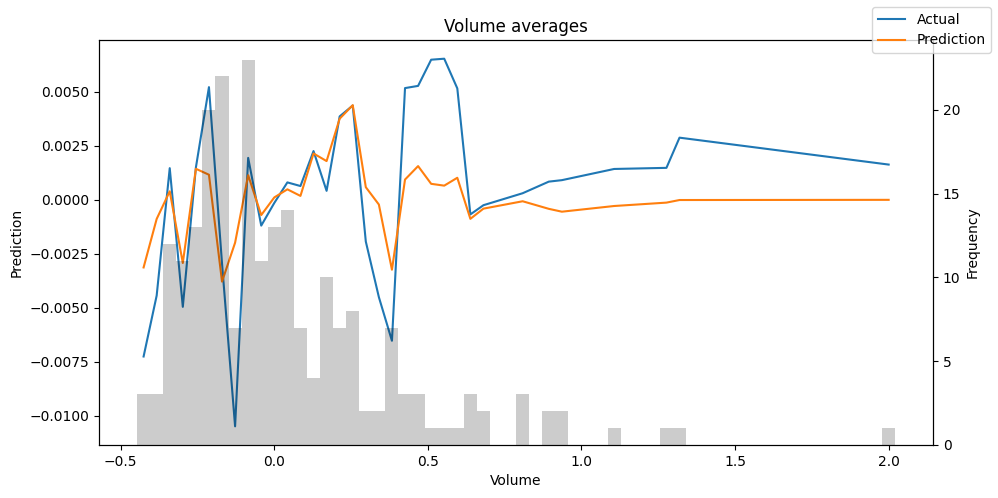

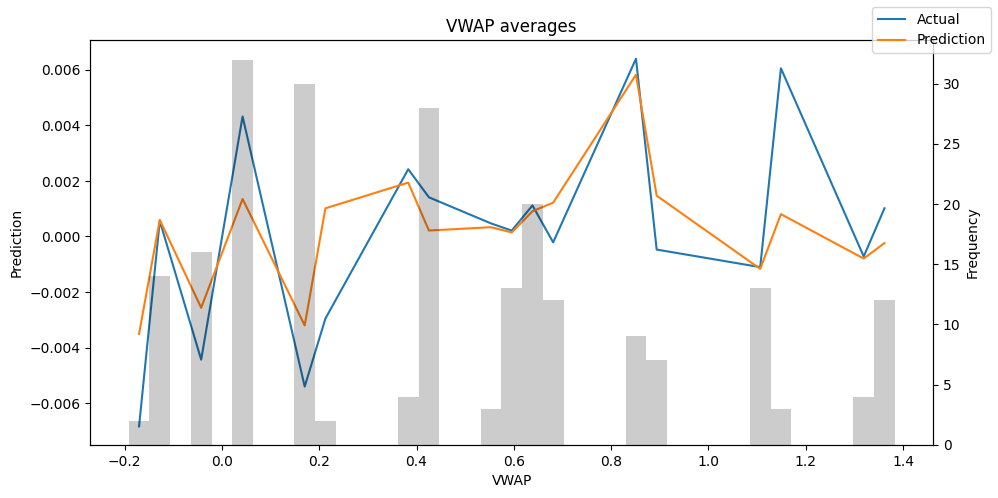

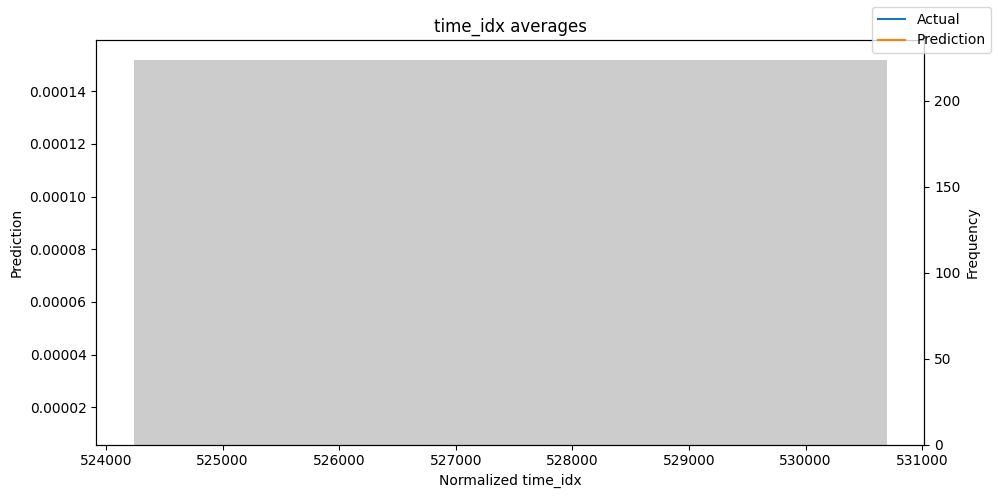

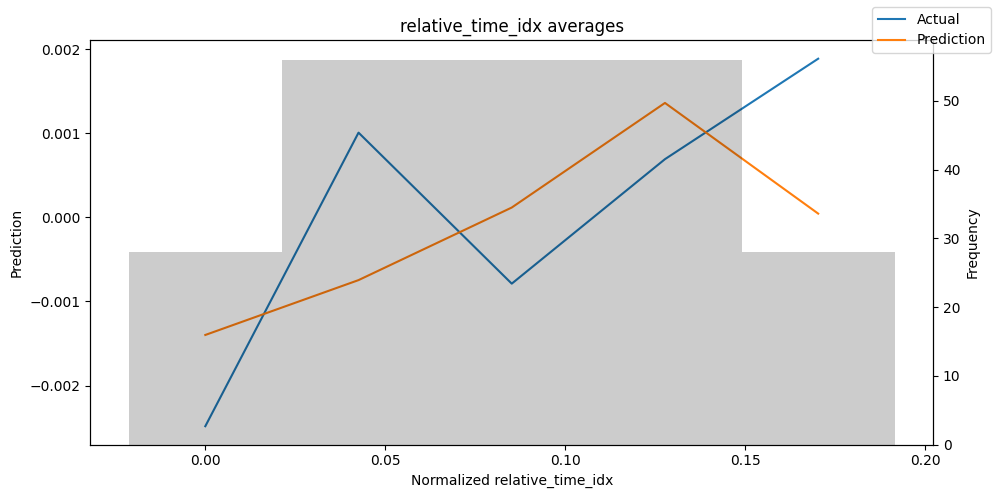

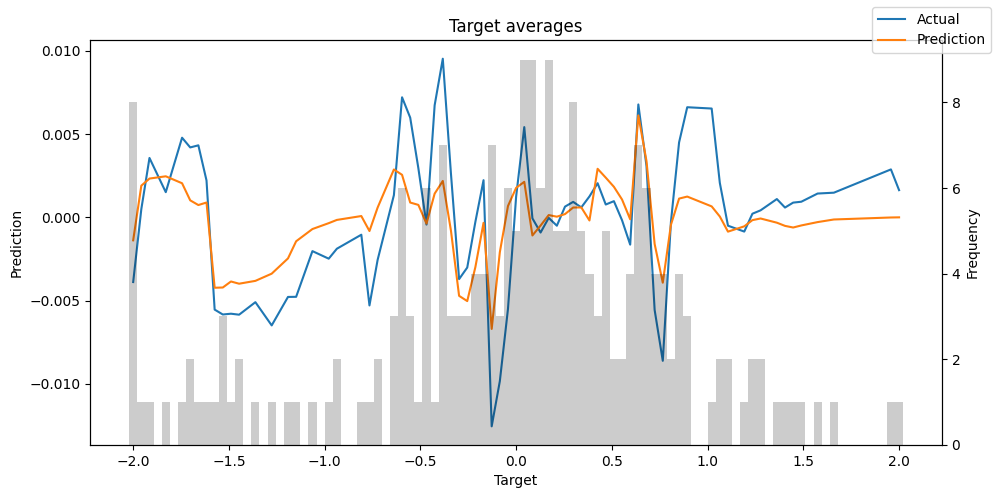

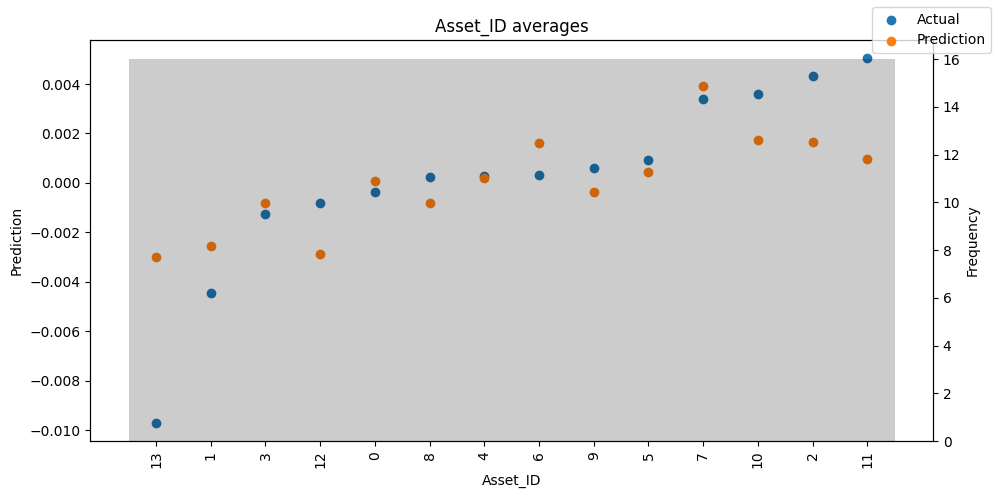

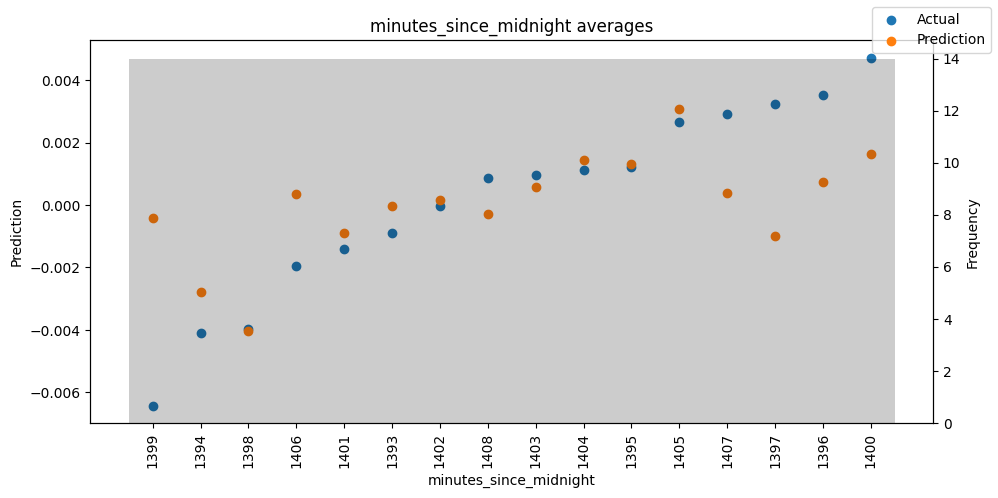

In [109]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

## Оценка признаков

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x475 with 1 Axes>,
 'decoder_variables': <Figure size 700x450 with 1 Axes>}

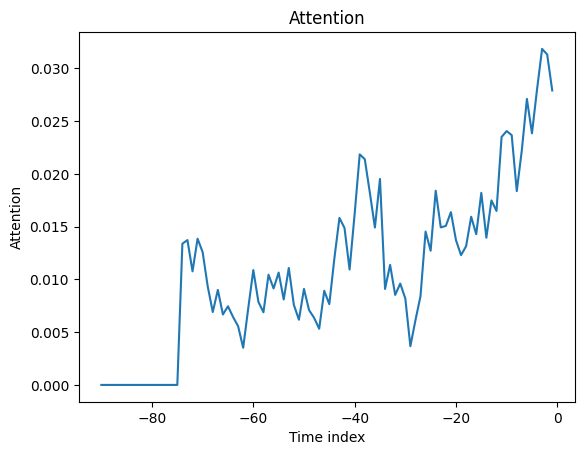

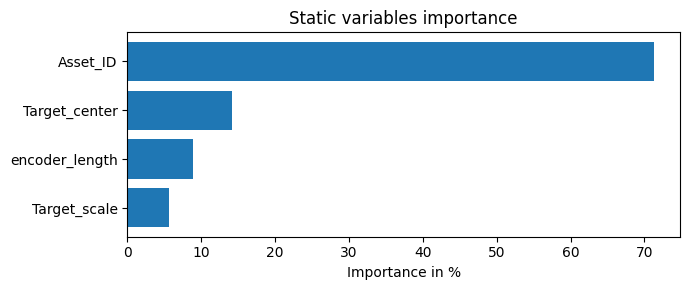

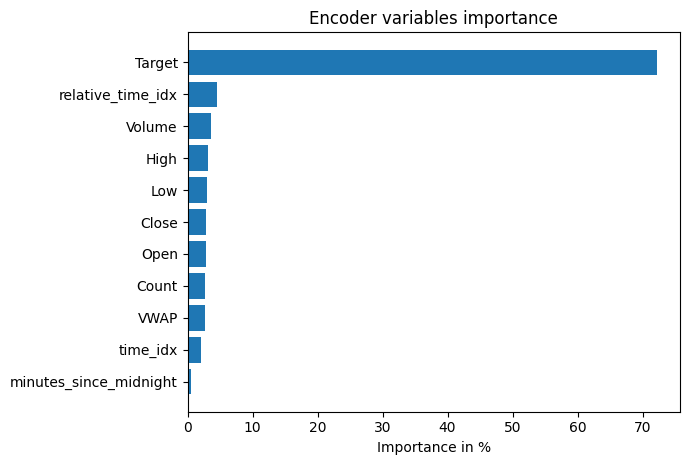

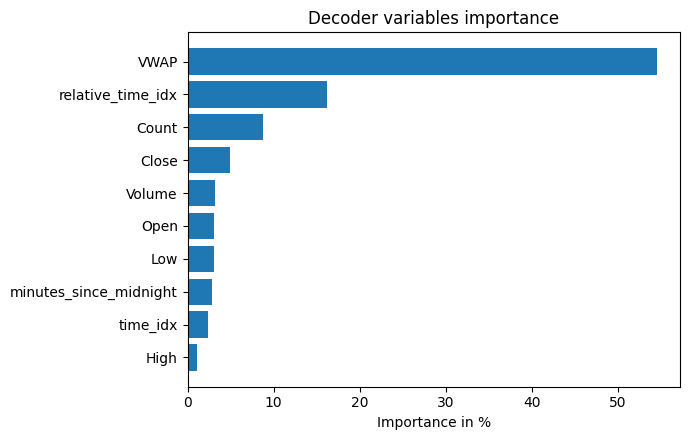

In [122]:
interpretation = best_tft.interpret_output(data_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [174]:
ac = data_val[data_val.Asset_ID == '2'].iloc[-16:].Target

In [177]:
pre = pd.DataFrame(data_predictions.output.prediction[6].transpose(0, 1)[4].cpu(), index=ac.index, columns=['Target'])

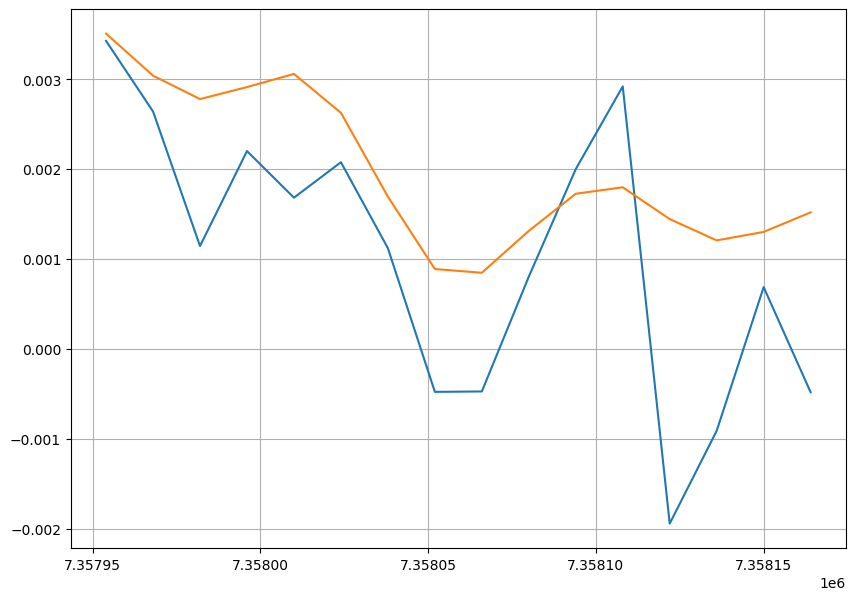

In [178]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ac)
ax.plot(pre)
plt.grid()
plt.show()

In [77]:
ac = data_val[data_val.Asset_ID == '10'].iloc[-16:].Target

In [78]:
pre = pd.DataFrame(data_predictions.output.prediction[2].reshape(-1, 1).cpu(), index=ac.index, columns=['Target'])

In [79]:
data_val

timestamp Asset_ID     Count      Open      High       Low  \
7356916 2021-09-20 22:15:00        0 -0.204050  0.676854  0.679997  0.678391   
7356917 2021-09-20 22:15:00        1 -0.068877  0.465839  0.466186  0.467826   
7356918 2021-09-20 22:15:00        2 -0.214397  0.090677  0.092403  0.093345   
7356919 2021-09-20 22:15:00        3  0.375511  1.412818  1.420185  1.414955   
7356920 2021-09-20 22:15:00        4 -0.218713  0.462571  0.462252  0.464478   
...                     ...      ...       ...       ...       ...       ...   
7358171 2021-09-20 23:44:00        9 -0.456604  0.039008  0.036389  0.036038   
7358172 2021-09-20 23:44:00       10 -0.318021  0.190100  0.187109  0.187867   
7358173 2021-09-20 23:44:00       11 -0.245332  0.200205  0.198529  0.195602   
7358174 2021-09-20 23:44:00       12 -0.258034 -0.144099 -0.145856 -0.145340   
7358175 2021-09-20 23:44:00       13  0.160086  0.861009  0.860743  0.861098   

            Close    Volume      VWAP    Target  time_idx  \
7356916  0.680936 -0.363319  0.679413 -0.000349    525494   
7356917  0.467258 -0.257880  0.466751  0.000242    525494   
7356918  0.094590 -0.220065  0.093276 -0.002527    525494   
7356919  1.422155  0.354568  1.417908  0.003879    525494   
7356920  0.463544 -0.262883  0.463338 -0.001077    525494   
...           ...       ...       ...       ...       ...   
7358171  0.032945 -0.408160  0.035595 -0.001154    525583   
7358172  0.185525 -0.347981  0.187979  0.009831    525583   
7358173  0.195547 -0.325713  0.196932  0.002568    525583   
7358174 -0.147643 -0.372271 -0.145983  0.000449    525583   
7358175  0.858056 -0.302740  0.859734  0.004163    525583   

        minutes_since_midnight    Weight  
7356916                   1335  4.304065  
7356917                   1335  6.779922  
7356918                   1335  2.397895  
7356919                   1335  4.406719  
7356920                   1335  3.555348  
...                        ...       ...  
7358171                   1424  2.397895  
7358172                   1424  1.098612  
7358173                   1424  1.609438  
7358174                   1424  2.079442  
7358175                   1424  1.791759  

[1260 rows x 13 columns]

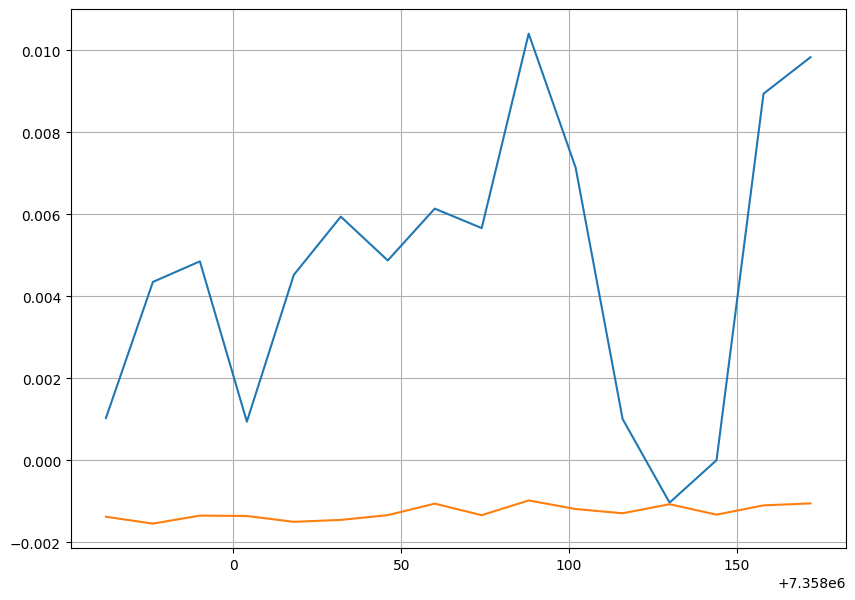

In [80]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ac)
ax.plot(pre)
plt.grid()
plt.show()

In [55]:
pre

Target
7357952 -0.001213
7357966 -0.001486
7357980 -0.001339
7357994 -0.001234
7358008 -0.001319
7358022 -0.001302
7358036 -0.001500
7358050 -0.001343
7358064 -0.001203
7358078 -0.001011
7358092 -0.001127
7358106 -0.001043
7358120 -0.001222
7358134 -0.001242
7358148 -0.000924
7358162 -0.000859

In [ ]:
from datetime import timedelta

# Now you can use timedelta
delta = timedelta(minutes=15)

In [ ]:
from itertools import product

assets = sorted(list(data_val.Asset_ID.unique()))
dates = pd.date_range(data_val.timestamp.max() - delta, data_val.timestamp.max(), freq='T')

combinations = list(product(dates, assets))

# Преобразуем комбинации в DataFrame
df_combinations = pd.DataFrame(combinations, columns=['timestamp', 'Asset_ID'])

df_combinations = df_combinations.sort_values(['Asset_ID', 'timestamp'])
pred = data_predictions.output.prediction.reshape(210, -1)
df_combinations['Target'] = pred.cpu()

# Построим наши прогнозы

In [ ]:
pred_val_data = df_combinations.set_index(['timestamp', 'Asset_ID']).sort_index().unstack('Asset_ID')

In [ ]:
pred_val_data.head()

In [ ]:
actual_data = data_val.loc[(data_val.timestamp >= '2021-09-20 23:31:00') & (data_val.timestamp <= '2021-09-20 23:45:00'), ['timestamp', 'Asset_ID', 'Target']]

In [ ]:
actual_data = actual_data.set_index(['timestamp', 'Asset_ID']).sort_index().unstack('Asset_ID')

In [ ]:
actual_data

In [ ]:
pred_val_data

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(actual_data.Target['10'])
ax.plot(pred_val_data.Target['10'])
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Target')
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt




plt.figure(figsize=(14, 7))
plt.plot(df)
plt.plot(df2)
plt.plot(df3)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [ ]:
raw_predictions = best_tft.predict(predict_dataloader, mode="raw", return_x=True)

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)